# Proyecto: Análisis espacial de eficiencia

## Librerías usadas

In [ ]:
### Instalación de paquetería
#! pip install networkx[default,extra]
# ! pip install circlify

In [2]:
## Librerías
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.io as pio
import circlify
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from shapely.geometry import Point, Polygon
import itertools
from itertools import permutations
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
plt.rc('figure', figsize=(8,8))
plt.rcParams.update({'figure.figsize': (8,8)})

## Creación de matriz de adyacencia entre actividades

In [3]:
### Ruta de datos
ruta_matriz = os.path.join('data', 'MIP.csv')

### Datos de MIP
mip =  pd.read_csv(ruta_matriz)
mip = mip.apply(pd.to_numeric, errors='coerce')

### Matriz de total
mip_total = mip[["Total"]]

### Matriz MIP sin total
mip = mip.drop('Total', axis=1)

### Nos quedamos con la matriz de porcentajes
mip = mip.div(mip_total['Total'], axis=0)


### Solo tomamos en cuenta las 5 actividades con la contribución más alta
# Aplicar la máscara
mip_top = mip.mask(mip < mip.apply(lambda x: x.nlargest(5).min()))

# Reemplazar los valores que no cumplan la condición por 0
mip_top = mip_top.fillna(0)

### Nos quedamos con una matriz que tenga 1 en las observaciones más altas
m1_aux = np.where(mip_top> 0, 1, 0)

# Creamos un arreglo de ceros del mismo tamaño que la matriz
arr = np.zeros_like(m1_aux)

# Recorremos la matriz y actualizamos el arreglo según lo indicado
for i in range(m1_aux.shape[0]):
    for j in range(i, m1_aux.shape[1]):
        if m1_aux[i, j] == 1 and m1_aux[j, i] == 1:
            arr[i, j] = 1
            arr[j, i] = 1

# Creamos el dataframe a partir del arreglo
m1 = pd.DataFrame(arr, columns=range(m1_aux.shape[1]), index=range(m1_aux.shape[0]))

m1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


### Complementos para gráficos

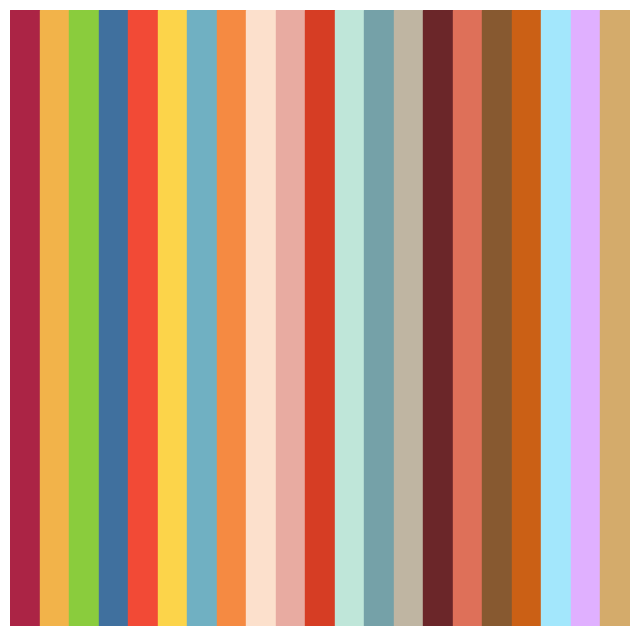

In [4]:
### Colores
color1 = (0.67, 0.14, 0.27) # Maroon-ish
color2 = (0.95, 0.70, 0.29) # Yellow
color3 = (0.54, 0.80, 0.24) # Green
color4 = (0.25, 0.44, 0.62) # Blue
color5 = (0.95, 0.29, 0.21) # Red
color6 = (0.99, 0.83, 0.29) # Yellow-ish
color7 = (0.44, 0.69, 0.76) # Blue-ish
color8 = (0.96, 0.54, 0.26) # Orange
color9 = (0.99, 0.88, 0.80) # Beige
color10 = (0.91, 0.67, 0.63) # Pink-ish
color11 = (0.84, 0.24, 0.14) # Red-ish
color12 = (0.75, 0.90, 0.85) # Light blue-ish
color13 = (0.46, 0.63, 0.66) # Grayish-blue
color14 = '#BFB5A2'  # beige-grey
color15 = (0.42, 0.15, 0.16) # Dark brown-ish
color16 = (0.87, 0.44, 0.35) # Peach
color17 = (0.53, 0.35, 0.19) # Brown-ish
color18 = '#CB6015'  # burnt orange
color19 = '#A3E7FC'  # pale blue
color20 = '#E0B0FF'  # light purple
color21 = (0.83, 0.67, 0.42) # Light brown

colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9, color10, color11, color12, color13, color14, color15, color16, color17, color18, color19, color20, color21]

fig, ax = plt.subplots()
for i in range(len(colors)):
    rect = plt.Rectangle((i, 0), 1, 1, color=colors[i])
    ax.add_artist(rect)

plt.xlim([0, len(colors)])
plt.ylim([0, 1])
plt.axis('off')
plt.show()

my_cmap = ListedColormap(colors)

## Análisis a nivel nacional

### Revisamos que funcione 

In [6]:
entidad = gpd.read_file("input/entidad.shp")
entidad.columns= entidad.columns.str.lower()
entidad['entidad'] = entidad['entidad'].str.title()
entidad = entidad[["entidad", "capital", "cve_edo", "geometry"]]
entidad.rename(columns={"cve_edo":"cve_ent"}, inplace = True)
entidad["cve_ent"] = pd.to_numeric(entidad["cve_ent"])

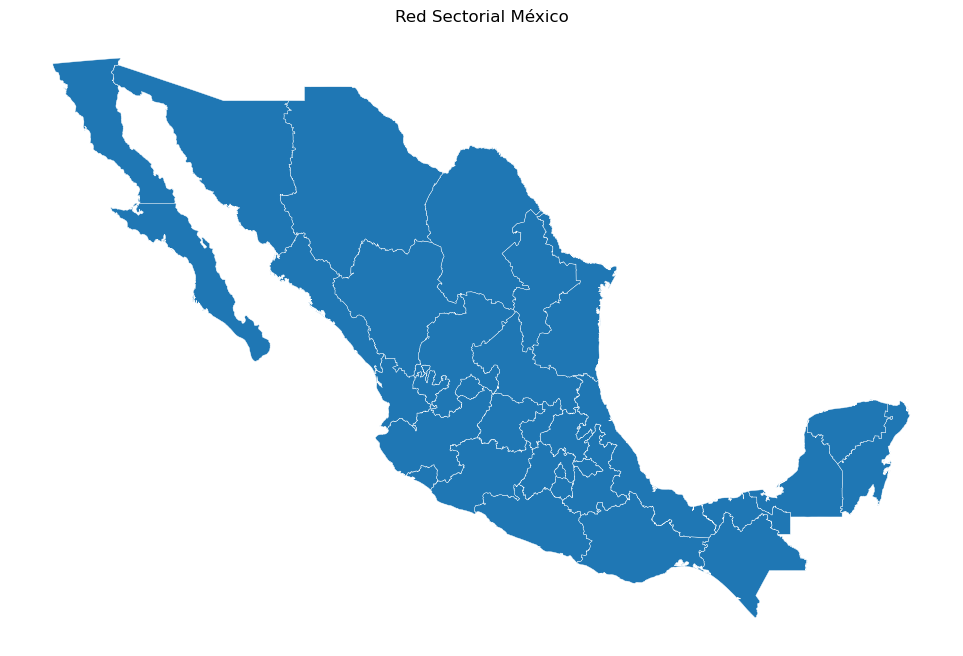

In [7]:
fig , ax = plt.subplots(1, figsize = (14,8))

entidad.plot(
  # column = 'cve_ent', 
  categorical = True, 
  legend = True,
  #cmap = 'Dark2',
  ax = ax,
  linewidth = 0.3,
  edgecolor = 'white',
  );

ax.set_axis_off();
ax.set_title("Red Sectorial México");

In [8]:
entidad.crs
crs = {'init':'epsg:4326'}

## Cargamos la base 

In [9]:
denue = pd.read_stata('input/denue_total_modelo.dta')
dict_limp = dict(zip(denue.actividad.unique().tolist(), [i.split('_', 1)[0] for i in denue.actividad.unique().tolist()]))
denue['actividad'] =  denue['actividad'].map(dict_limp)
denue = denue.reset_index()
denue.rename(columns={"index":"empresa"}, inplace = True)
scian = denue.actividad.unique().tolist()

In [10]:
geometry = [Point(xy) for xy in zip(denue['longitud'], denue['latitud'])]
geo_denue = gpd.GeoDataFrame(denue, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_denue = geo_denue.drop(["latitud" , "longitud"], axis=1)

C:\Users\zyany\anaconda3\envs\proyecto_redes\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Análisis de los nodos 

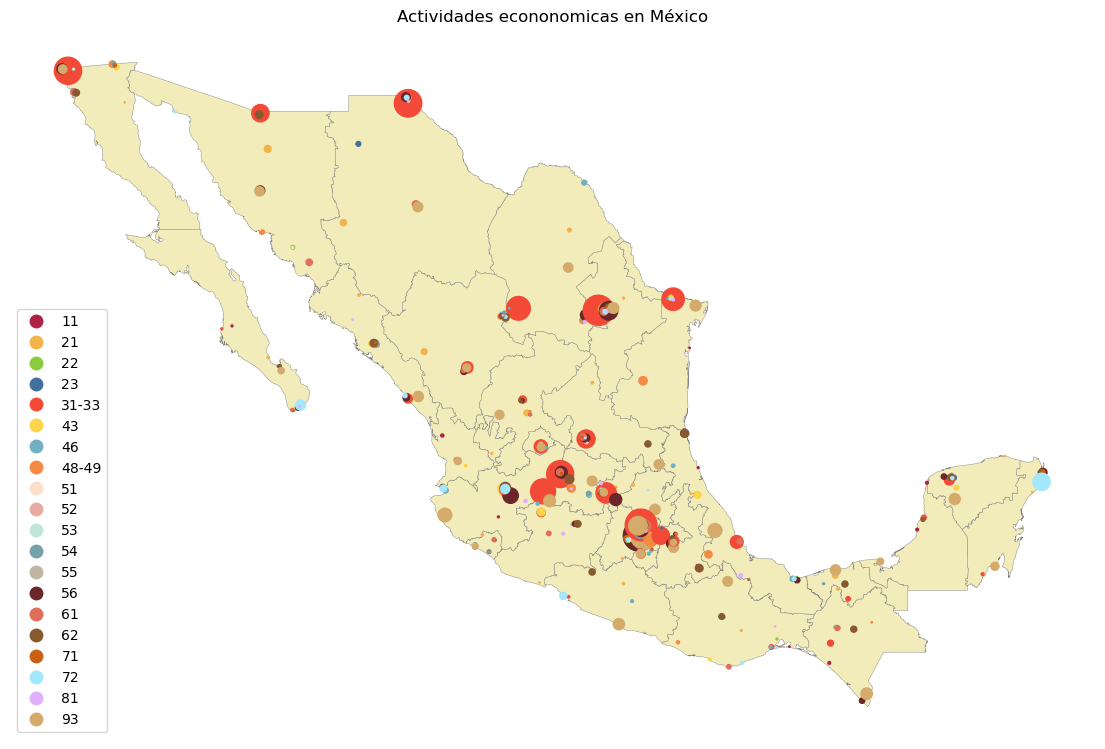

In [11]:
fig , ax = plt.subplots(1, figsize = (14,10))

entidad.plot(
ax = ax,
#cmap = 'colors',
color='#F2EBBA', 
edgecolor='gray',
linewidth = 0.3
);

geo_denue.plot(ax=ax, markersize = "ponderador", column = "actividad", cmap = my_cmap, marker='o', legend= True)

ax.set_axis_off();
ax.set_title("Actividades econonomicas en México");

plt.savefig('img/red_mex.jpg', dpi  = 400, bbox_inches='tight')

## Creamos la red 

In [12]:
edgelist = pd.read_csv('input/edgelist_clean_oneway.csv')  
edgelist = edgelist.loc[(edgelist.link == 1),]
tuples_edges = list(zip(edgelist.source, edgelist.target))

In [13]:
edges = []
for tup in range(len(tuples_edges)):
    source = denue.loc[(denue.actividad == tuples_edges[tup][0]),].empresa.unique().tolist()
    target = denue.loc[(denue.actividad == tuples_edges[tup][1]),].empresa.unique().tolist()
    edges.extend(list(itertools.product(source, target)))

df_edges = pd.DataFrame(edges, columns =['source','target'])

In [14]:
G = nx.Graph() 
G.add_edges_from(df_edges.values) 
print("Number of nodes/empresas", len(G))
print("Number of edges/comercio", len(G.edges))

Number of nodes/empresas 348
Number of edges/comercio 6723


In [15]:
# Add latitude and longitude to nodes, limit nodes to continental US
for v in list(G.nodes()):
    try:
        G.nodes[v]['lat'] = denue.loc[(denue.empresa == v),["latitud","longitud","actividad","ponderador","entidad"]].values[0][0]
        G.nodes[v]['long'] = denue.loc[(denue.empresa == v),["latitud","longitud","actividad","ponderador","entidad"]].values[0][1]
        G.nodes[v]['scian'] = denue.loc[(denue.empresa == v),["latitud","longitud","actividad","ponderador","entidad"]].values[0][2]
        G.nodes[v]['weight'] = denue.loc[(denue.empresa == v),["latitud","longitud","actividad","ponderador","entidad"]].values[0][3]
        G.nodes[v]['ent'] = denue.loc[(denue.empresa == v),["latitud","longitud","actividad","ponderador","entidad"]].values[0][4]
        
    except KeyError:
        G.remove_node(v)

In [16]:
pos = dict()
for v in G.nodes:
    long = G.nodes[v]['long']
    lat = G.nodes[v]['lat']
    pos[v] = (long, lat)

In [17]:
node_color =  []

for v in G:
    if G.nodes[v]["scian"] == "11":
        node_color.append(color1)
    elif G.nodes[v]["scian"] == "21":
        node_color.append(color2)
    elif G.nodes[v]["scian"] == "22":
        node_color.append(color3)
    elif G.nodes[v]["scian"] == "23":
        node_color.append(color4)
    elif G.nodes[v]["scian"] == "31-33":
        node_color.append(color5)
    elif G.nodes[v]["scian"] == "43":
        node_color.append(color6)
    elif G.nodes[v]["scian"] == "46":
        node_color.append(color7)
    elif G.nodes[v]["scian"] == "48-49":
        node_color.append(color8)
    elif G.nodes[v]["scian"] == "51":
        node_color.append(color9)
    elif G.nodes[v]["scian"] == "52":
        node_color.append(color10)
    elif G.nodes[v]["scian"] == "53":
        node_color.append(color11)
    elif G.nodes[v]["scian"] == "54":
        node_color.append(color12)
    elif G.nodes[v]["scian"] == "55":
        node_color.append(color13)
    elif G.nodes[v]["scian"] == "56":
        node_color.append(color14)
    elif G.nodes[v]["scian"] == "61":
        node_color.append(color15)
    elif G.nodes[v]["scian"] == "61":
        node_color.append(color16)
    elif G.nodes[v]["scian"] == "71":
        node_color.append(color17)
    elif G.nodes[v]["scian"] == "72":
        node_color.append(color18)
    elif G.nodes[v]["scian"] == "81":
        node_color.append(color19)
    elif G.nodes[v]["scian"] == "93":
        node_color.append(color20)
    else:
        node_color.append('black')

C:\Users\zyany\anaconda3\envs\proyecto_redes\lib\site-packages\matplotlib\cbook\__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


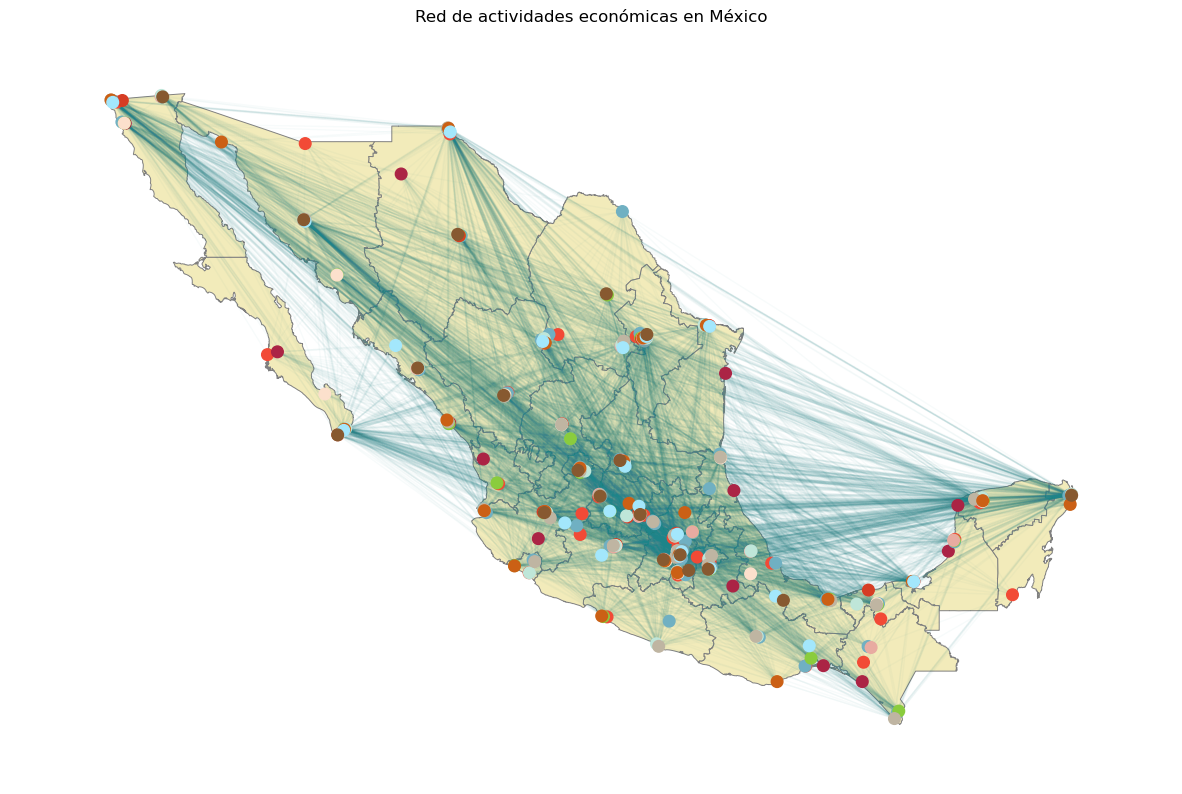

In [18]:
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1)

entidad.plot(ax=ax, color='#F2EBBA', edgecolor='gray', linewidth=0.7)
nx.draw_networkx_nodes(G, pos=pos, node_size=70, node_color= node_color)
nx.draw_networkx_edges(G, pos=pos, edge_color='#1E8489', alpha=0.03, arrows=False)

ax.set_axis_off()
ax.set_title("Red de actividades económicas en México")
legend= True
plt.savefig('img/net_mex_1.jpg', dpi  = 400, bbox_inches='tight')

## Medidas de centralidad

In [19]:
### Añadir diccionario de actividades
# Crear una lista con las líneas de texto
lineas = [
    '11 - Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza',
    '21 - Minería',
    '22 - Generación, transmisión y distribución de energía eléctrica, suministro de agua y de gas por ductos al consumidor final',
    '23 - Construcción',
    '31-33 - Industrias manufactureras',
    '43 - Comercio al por mayor',
    '46 - Comercio al por menor',
    '48-49 - Transportes, correos y almacenamiento',
    '51 - Información en medios masivos',
    '52 - Servicios financieros y de seguros',
    '53 - Servicios inmobiliarios y de alquiler de bienes muebles e intangibles',
    '54 - Servicios profesionales, científicos y técnicos',
    '55 - Corporativos',
    '56 - Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación',
    '61 - Servicios educativos',
    '62 - Servicios de salud y de asistencia social',
    '71 - Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos',
    '72 - Servicios de alojamiento temporal y de preparación de alimentos y bebidas',
    '81 - Otros servicios excepto actividades gubernamentales',
    '93 - Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales'
]

# Crear dos listas vacías para almacenar lo que está antes y después del guión
actividad = []
nom_act = []

# Iterar por cada línea en la lista y separar la línea en dos partes
for linea in lineas:
    partes = linea.split(" - ")
    actividad.append(partes[0])
    nom_act.append(partes[1])

# Diccionario de actividades
dic_act = pd.DataFrame({'actividad': actividad, 'nom_act': nom_act})
dic_act

,actividad,nom_act
0,11,"Agricultura, cría y explotación de animales, a..."
1,21,Minería
2,22,"Generación, transmisión y distribución de ener..."
3,23,Construcción
4,31-33,Industrias manufactureras
5,43,Comercio al por mayor
6,46,Comercio al por menor
7,48-49,"Transportes, correos y almacenamiento"
8,51,Información en medios masivos
9,52,Servicios financieros y de seguros


(array([50., 62.,  0., 86., 26.,  0., 51.,  0., 63., 10.]),
 array([10., 17., 24., 31., 38., 45., 52., 59., 66., 73., 80.]),
 <BarContainer object of 10 artists>)

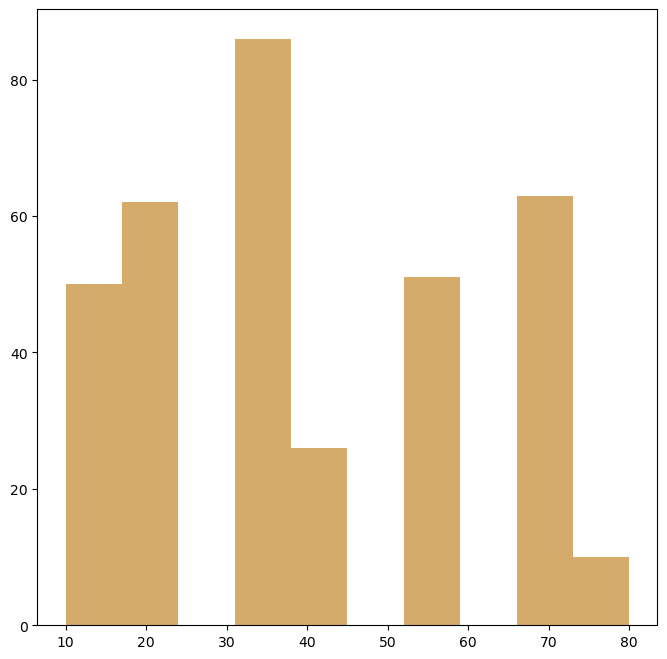

In [20]:
 #Crear un diccionario con los atributos de los nodos
node_dict = dict(G.nodes(data=True))

# Crear un diccionario para cada medida de centralidad
bc_dict = nx.betweenness_centrality(G)
cc_dict = nx.closeness_centrality(G)
ec_dict = nx.eigenvector_centrality(G)
dc_dict = nx.degree_centrality(G)
cluster_dict = nx.clustering(G)
avg_neighbor_degree_dict = nx.average_neighbor_degree(G)

# Crear un DataFrame con las medidas de centralidad y estadísticas descriptivas
df = pd.DataFrame({'grado':  pd.Series(dict(G.degree())),
                   'betweenness': pd.Series(bc_dict),
                   'closeness': pd.Series(cc_dict),
                   'eigenvector': pd.Series(ec_dict),
                   'degree_centrality': pd.Series(dc_dict),
                   'cluster_coefficient': pd.Series(cluster_dict),
                    'avg_neighbor_degree': pd.Series(avg_neighbor_degree_dict),   
                   'act': pd.Series(nx.get_node_attributes(G, 'scian')),
                  'entidad': pd.Series(nx.get_node_attributes(G, 'ent'))})

# Ordenar el DataFrame por la columna de grado y seleccionar las primeras 50 filas
df_sorted = df.sort_values(by='degree_centrality', ascending=False)

# Renombrar columna para poder hacer merge
df_sorted = df_sorted.rename(columns={'act': 'actividad'})

# Añadimos los nombres de las actividades
df_sorted = pd.merge(df_sorted, dic_act, on='actividad')


# Guardar el archivo en excel
df_sorted.to_excel("tabla/estadisticos.xlsx", index=False)

# Finalmente hacemos un análisis por tipo de actividad
df_grouped = df_sorted.groupby('entidad')
df_stats = df_grouped.describe()

# Para guardar la tabla
# Guardar el archivo en excel
df_stats.to_excel("tabla/statsent.xlsx", index=True)
# df_stats

# Obtener los grados de los nodos
degrees = dict(G.degree())
# Hacer el histograma de los grados
plt.hist(list(dict(G.degree()).values()), bins=range(10, 85, 7), color=color21)

In [21]:
# Hacemos una tabla con el top y el bottom 25

# Crear un dataframe con las primeras 25 observaciones
df_top = df_sorted.head(25)

# Crear un dataframe con las últimas 25 observaciones
df_bottom = df_sorted.tail(25)

# Concatenar los dos dataframes
df_sum = pd.concat([df_top, df_bottom])


# Guardar el archivo en excel
df_sum.to_excel("tabla/topbot.xlsx", index=False)

# Imprimir el nuevo dataframe
df_sum

,grado,betweenness,closeness,eigenvector,degree_centrality,cluster_coefficient,avg_neighbor_degree,actividad,entidad,nom_act
0,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,CHIHUAHUA,Corporativos
1,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,CIUDAD DE MÉXICO,Corporativos
2,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,YUCATÁN,Corporativos
3,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,VERACRUZ DE IGNACIO DE LA LLAVE,Corporativos
4,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,QUINTANA ROO,Corporativos
5,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,NUEVO LEÓN,Corporativos
6,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,MÉXICO,Corporativos
7,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,GUANAJUATO,Corporativos
8,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,BAJA CALIFORNIA,Corporativos
9,76,0.004435,0.236653,1.114437e-01,0.219020,0.29193,44.947368,55,DURANGO,Corporativos


In [22]:
# Finalmente hacemos un análisis por tipo de actividad
df_grouped = df_sorted.groupby('entidad')
df_stats = df_grouped.describe()

# Para guardar la tabla
# Guardar el archivo en excel
df_stats.to_excel("tabla/statsent.xlsx", index=True)
df_stats


grado                              \
                                         count       mean        std   min   
entidad                                                                      
AGUASCALIENTES                             9.0  38.888889  20.883273  14.0   
BAJA CALIFORNIA                           15.0  38.066667  21.372434  10.0   
BAJA CALIFORNIA SUR                       11.0  38.454545  20.166128  14.0   
CAMPECHE                                  11.0  38.454545  20.704413  10.0   
CHIAPAS                                    7.0  36.714286  24.081212  10.0   
CHIHUAHUA                                 13.0  40.769231  21.335236  14.0   
CIUDAD DE MÉXICO                          15.0  38.000000  21.394258  10.0   
COAHUILA DE ZARAGOZA                      13.0  35.615385  20.085395  10.0   
COLIMA                                     7.0  44.142857  20.892013  14.0   
DURANGO                                   10.0  40.300000  24.111086  14.0   
GUANAJUATO                                14.0  38.500000  22.110735  10.0   
GUERRERO                                   6.0  46.333333  21.987875  14.0   
HIDALGO                                   11.0  38.363636  20.737757  10.0   
JALISCO                                   14.0  35.357143  19.321599  10.0   
MICHOACÁN DE OCAMPO                       10.0  36.900000  22.481845  10.0   
MORELOS                                    9.0  38.888889  20.883273  14.0   
MÉXICO                                    14.0  38.500000  22.110735  10.0   
NAYARIT                                    7.0  44.285714  20.790337  14.0   
NUEVO LEÓN                                14.0  38.500000  22.110735  10.0   
OAXACA                                    10.0  38.100000  19.913424  14.0   
PUEBLA                                    14.0  35.357143  19.321599  10.0   
QUERÉTARO                                 12.0  36.916667  20.398121  10.0   
QUINTANA ROO                              12.0  42.500000  21.258154  14.0   
SAN LUIS POTOSÍ                           11.0  37.454545  21.304289  10.0   
SINALOA                                   12.0  34.250000  20.244528  10.0   
SONORA                                    13.0  35.692308  20.068153  10.0   
TABASCO                                    7.0  44.142857  22.740775  14.0   
TAMAULIPAS                                12.0  38.666667  18.763278  14.0   
TLAXCALA                                   4.0  41.000000  23.280893  14.0   
VERACRUZ DE IGNACIO DE LA LLAVE           13.0  38.230769  22.136523  10.0   
YUCATÁN                                   12.0  41.666667  22.431039  10.0   
ZACATECAS                                  6.0  42.666667  24.541122  14.0   

                                                                    \
                                            25%   50%    75%   max   
entidad                                                              
AGUASCALIENTES                            21.00  31.0  52.00  72.0   
BAJA CALIFORNIA                           20.50  31.0  52.50  76.0   
BAJA CALIFORNIA SUR                       20.50  32.0  52.50  72.0   
CAMPECHE                                  25.00  32.0  52.50  72.0   
CHIAPAS                                   22.50  31.0  49.50  72.0   
CHIHUAHUA                                 21.00  32.0  53.00  76.0   
CIUDAD DE MÉXICO                          20.50  31.0  52.50  76.0   
COAHUILA DE ZARAGOZA                      20.00  31.0  52.00  72.0   
COLIMA                                    31.00  42.0  59.50  72.0   
DURANGO                                   20.25  31.0  63.25  76.0   
GUANAJUATO                                20.25  31.0  52.75  76.0   
GUERRERO                                  33.75  47.0  63.25  72.0   
HIDALGO                                   25.00  31.0  52.50  72.0   
JALISCO                                   20.25  31.0  49.50  72.0   
MICHOACÁN DE OCAMPO                       19.25  31.0  52.75  72.0   
MORELOS                                   21.00  3

#### Degree distribution


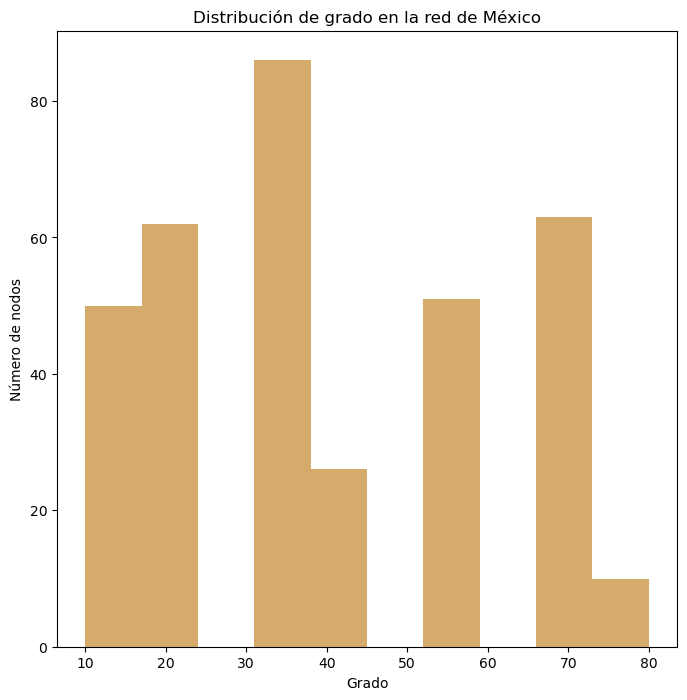

In [23]:
# Obtener los grados de los nodos
degrees = dict(G.degree())
# Hacer el histograma de los grados
plt.hist(list(dict(G.degree()).values()), bins=range(10, 85, 7), color=color21)
# Añadir títulos y etiquetas
plt.title("Distribución de grado en la red de México")
plt.xlabel("Grado")
plt.ylabel("Número de nodos")

plt.savefig("img/dg_ds.png")

# Mostrar el gráfico
plt.show()

## Limpieza de datos y creación de redes a nivel estatal

In [62]:
### Rutas
ruta_bc = os.path.join('data', 'denue_bc.csv')
ruta_cdmx = os.path.join('data', 'denue_cdmx.csv')
ruta_v = os.path.join('data', 'denue_v.csv')
# ruta_matriz = os.path.join('data', 'm1.csv')

In [11]:
### Añadir diccionario de actividades
# Crear una lista con las líneas de texto
lineas = [
    '11 - Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza',
    '21 - Minería',
    '22 - Generación, transmisión y distribución de energía eléctrica, suministro de agua y de gas por ductos al consumidor final',
    '23 - Construcción',
    '31-33 - Industrias manufactureras',
    '43 - Comercio al por mayor',
    '46 - Comercio al por menor',
    '48-49 - Transportes, correos y almacenamiento',
    '51 - Información en medios masivos',
    '52 - Servicios financieros y de seguros',
    '53 - Servicios inmobiliarios y de alquiler de bienes muebles e intangibles',
    '54 - Servicios profesionales, científicos y técnicos',
    '55 - Corporativos',
    '56 - Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación',
    '61 - Servicios educativos',
    '62 - Servicios de salud y de asistencia social',
    '71 - Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos',
    '72 - Servicios de alojamiento temporal y de preparación de alimentos y bebidas',
    '81 - Otros servicios excepto actividades gubernamentales',
    '93 - Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales'
]

# Crear dos listas vacías para almacenar lo que está antes y después del guión
actividad = []
nom_act = []

# Iterar por cada línea en la lista y separar la línea en dos partes
for linea in lineas:
    partes = linea.split(" - ")
    actividad.append(partes[0])
    nom_act.append(partes[1])

# Diccionario de actividades
dic_act = pd.DataFrame({'actividad': actividad, 'nom_act': nom_act})
dic_act

,actividad,nom_act
0,11,"Agricultura, cría y explotación de animales, a..."
1,21,Minería
2,22,"Generación, transmisión y distribución de ener..."
3,23,Construcción
4,31-33,Industrias manufactureras
5,43,Comercio al por mayor
6,46,Comercio al por menor
7,48-49,"Transportes, correos y almacenamiento"
8,51,Información en medios masivos
9,52,Servicios financieros y de seguros


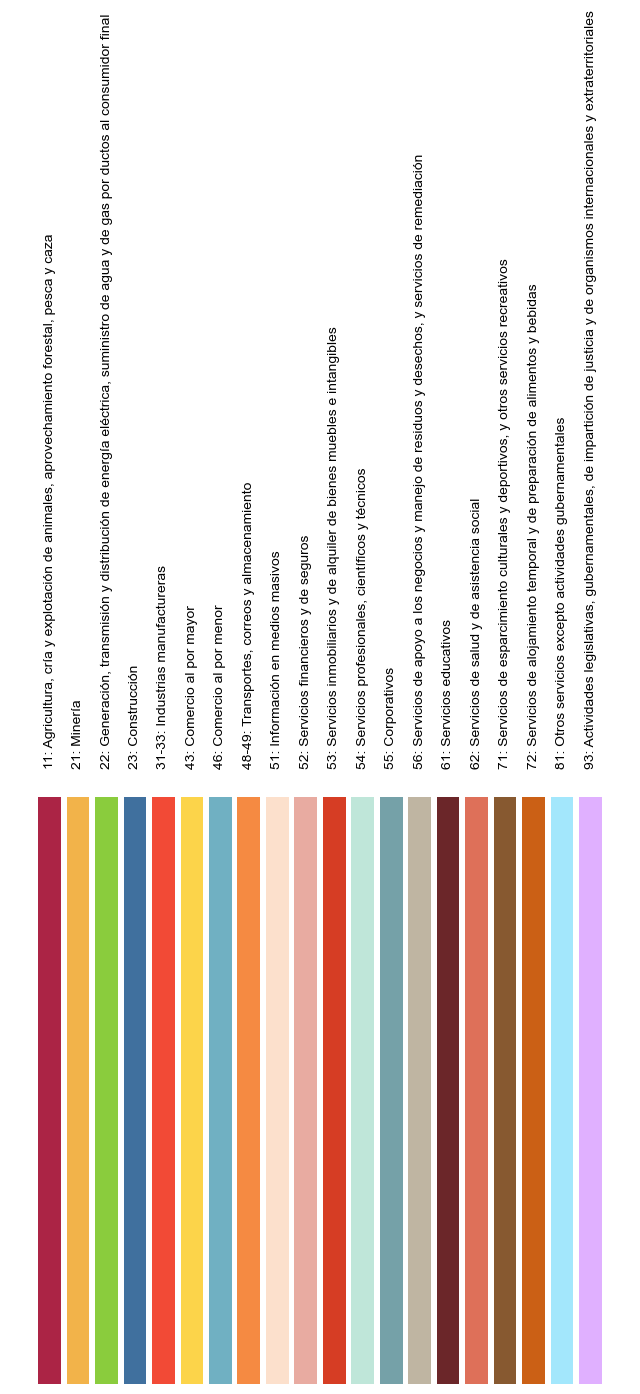

In [13]:
# Familia de fuentes
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']

# Lista de colores
colores = [color1, color2, color3, color4, color5, color6, color7, color8, color9, color10,
           color11, color12, color13, color14, color15, color16, color17, color18, color19, color20]

# Crear una lista de etiquetas para cada barra con la estructura "actividad: nom_act"
etiquetas = [f"{actividad}: {nom_act}" for actividad, nom_act in zip(dic_act['actividad'], dic_act['nom_act'])]

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Añadir las barras
ax.bar(range(len(colores)), [1]*len(colores), color=colores, align='center')

# Añadir las etiquetas verticales
for i, etiqueta in enumerate(etiquetas):
    ax.text(i, 1.05, etiqueta, rotation=90, ha='center', va='bottom')

# Configurar los ejes y el título
ax.axis('off')

plt.savefig("img/codigo_colo.png")
# Mostrar la gráfica
plt.show()

In [14]:
### Diccionario de colores asignados a cada categoría
cat_colores = {'11': color1, '21': color2, '22': color3, '23': color4, '31-33': color5,
                   '43': color6, '46': color7, '48-49': color8, '51': color9, '52': color10,
                   '53': color11, '54': color12, '55': color13, '56': color14, '61': color15,
                   '62': color16, '71': color17, '72': color18, '81': color19, '93': color20}


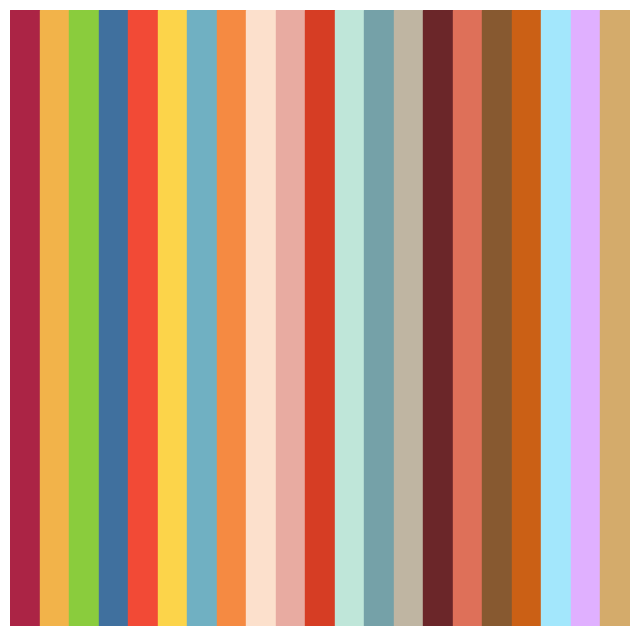

In [12]:
### Colores
color1 = (0.67, 0.14, 0.27) # Maroon-ish
color2 = (0.95, 0.70, 0.29) # Yellow
color3 = (0.54, 0.80, 0.24) # Green
color4 = (0.25, 0.44, 0.62) # Blue
color5 = (0.95, 0.29, 0.21) # Red
color6 = (0.99, 0.83, 0.29) # Yellow-ish
color7 = (0.44, 0.69, 0.76) # Blue-ish
color8 = (0.96, 0.54, 0.26) # Orange
color9 = (0.99, 0.88, 0.80) # Beige
color10 = (0.91, 0.67, 0.63) # Pink-ish
color11 = (0.84, 0.24, 0.14) # Red-ish
color12 = (0.75, 0.90, 0.85) # Light blue-ish
color13 = (0.46, 0.63, 0.66) # Grayish-blue
color14 = '#BFB5A2'  # beige-grey
color15 = (0.42, 0.15, 0.16) # Dark brown-ish
color16 = (0.87, 0.44, 0.35) # Peach
color17 = (0.53, 0.35, 0.19) # Brown-ish
color18 = '#CB6015'  # burnt orange
color19 = '#A3E7FC'  # pale blue
color20 = '#E0B0FF'  # light purple
color21 = (0.83, 0.67, 0.42) # Light brown

colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9, color10, color11, color12, color13, color14, color15, color16, color17, color18, color19, color20, color21]

fig, ax = plt.subplots()
for i in range(len(colors)):
    rect = plt.Rectangle((i, 0), 1, 1, color=colors[i])
    ax.add_artist(rect)

plt.xlim([0, len(colors)])
plt.ylim([0, 1])
plt.axis('off')
plt.show()

### Baja California

#### Creación de matriz de adyacencia

In [15]:
##### Datos
data_bc = pd.read_csv(ruta_bc)
## Solamente nos quedamos con las columnas de datos necesarias
data_bc = data_bc[["nombre_act", "cve_mun", "municipio", "latitud", "longitud", "actividad"]]
## Generalizamos la codificación para que sea igual a nuestra matriz m1
data_bc.loc[data_bc['actividad'] == '46_1', 'actividad'] = '46'
data_bc.loc[data_bc['actividad'] == '46_2', 'actividad'] = '46'
data_bc.loc[data_bc['actividad'] == '46_3', 'actividad'] = '46'
data_bc.loc[data_bc['actividad'] == '72_1', 'actividad'] = '72'
data_bc.loc[data_bc['actividad'] == '81_1', 'actividad'] = '81'

## Añadimos el nombre de las actividades
data_bc = pd.merge(data_bc, dic_act, on='actividad')
data_bc

,nombre_act,cve_mun,municipio,latitud,longitud,actividad,nom_act
0,"Piscicultura y otra acuicultura, excepto camar...",1,Ensenada,31.860846,-116.59454,11,"Agricultura, cría y explotación de animales, a..."
1,Otros servicios relacionados con la agricultura,1,Ensenada,31.724861,-116.57960,11,"Agricultura, cría y explotación de animales, a..."
2,Otros servicios relacionados con la agricultura,1,Ensenada,31.876680,-116.62714,11,"Agricultura, cría y explotación de animales, a..."
3,Pesca de túnidos,1,Ensenada,31.899590,-116.69997,11,"Agricultura, cría y explotación de animales, a..."
4,"Pesca y captura de peces, crustáceos, moluscos...",2,Mexicali,31.023849,-114.83820,11,"Agricultura, cría y explotación de animales, a..."
...,...,...,...,...,...,...,...
636,Administración pública en general,4,Tijuana,32.540081,-116.98896,93,"Actividades legislativas, gubernamentales, de ..."
637,Administración pública en general,4,Tijuana,32.549580,-116.92439,93,"Actividades legislativas, gubernamentales, de ..."
638,Administración pública en general,2,Mexicali,32.653248,-115.38746,93,"Actividades legislativas, gubernamentales, de ..."
639,Actividades administrativas de instituciones d...,4,Tijuana,32.532257,-117.01752,93,"Actividades legislativas, gubernamentales, de ..."


In [16]:
# Observaciones
n_act_bc = data_bc['actividad'].value_counts()

# Porcentaje
per_act_bc = data_bc['actividad'].value_counts(normalize=True) * 100

# Crear data frame
data_act_bc = pd.DataFrame({'cuenta': n_act_bc, 'porcentaje': per_act_bc})

# Ordenar por observaciones
data_act_bc = data_act_bc.sort_values('cuenta', ascending=False)

# Mostrar
data_act_bc


,cuenta,porcentaje
31-33,383,59.750390
56,51,7.956318
93,38,5.928237
61,25,3.900156
62,22,3.432137
48-49,22,3.432137
46,18,2.808112
23,16,2.496100
43,15,2.340094
72,11,1.716069


In [17]:
### Calculamos distancia harvesine entre las empresas
# Convertimos las coordenadas de grados a radianes
coords_bc = data_bc[['latitud', 'longitud']].applymap(radians)
# coords_bc = data_bc[['latitud', 'longitud']]
# Calculamos la matriz de distancias Haversine
dist_matrix_bc = haversine_distances(coords_bc)
m2_bc = pd.DataFrame(dist_matrix_bc)
m2_bc = m2_bc* 6371000/1000
m2_bc

,0,1,2,3,4,5,6,7,8,9,...,631,632,633,634,635,636,637,638,639,640
0,0.000000,15.186626,3.546443,10.847096,190.846902,2.878516,139.161036,80.532996,2.933379,2.878516,...,135.963515,136.876465,83.783895,136.873923,136.361380,84.152509,82.632845,143.689025,84.603761,138.327333
1,15.186626,0.000000,17.469093,22.513348,182.773684,16.608157,148.074292,94.870375,17.218535,16.608157,...,145.128743,146.016030,97.935613,145.987671,145.486648,98.503168,97.281189,152.451717,98.795739,146.667306
2,3.546443,17.469093,0.000000,7.332863,194.392762,0.874689,140.496169,77.615562,0.671333,0.874689,...,137.232797,138.151746,80.791468,138.156446,137.641355,81.242415,79.878083,145.059557,81.627242,139.816693
3,10.847096,22.513348,7.332863,0.000000,201.650158,7.977169,144.536498,72.596208,7.990012,7.977169,...,141.157352,142.085916,75.551077,142.103893,141.584908,76.231541,75.295443,149.158249,76.429421,144.137922
4,190.846902,182.773684,194.392762,201.650158,0.000000,193.689781,188.324400,260.950439,193.764929,193.689781,...,189.822264,189.900762,265.156119,189.618174,189.543095,264.096936,260.108798,188.462792,265.636827,181.820894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,84.152509,98.503168,81.242415,76.231541,264.096936,82.117101,145.906034,3.635336,81.607055,82.117101,...,141.684738,142.580843,3.478968,142.751268,142.267288,0.000000,6.143883,150.553723,2.815108,148.910287
637,82.632845,97.281189,79.878083,75.295443,260.108798,80.750200,139.788057,6.507182,80.199954,80.750200,...,135.564915,136.459807,9.434965,136.631182,136.147997,6.143883,0.000000,144.431296,8.939819,142.820633
638,143.689025,152.451717,145.059557,149.158249,188.462792,145.244362,4.797868,149.603758,144.584684,145.244362,...,8.895671,7.981387,153.625476,7.827337,8.327946,150.553723,144.431296,0.000000,153.300481,7.418381
639,84.603761,98.795739,81.627242,76.429421,265.636827,82.501502,148.647836,4.714760,82.010916,82.501502,...,144.428666,145.326126,1.075550,145.495472,145.010611,2.815108,8.939819,153.300481,0.000000,151.624399


In [18]:
# Vemos los estadísticos de las distancias
m2_bc.describe()

,0,1,2,3,4,5,6,7,8,9,...,631,632,633,634,635,636,637,638,639,640
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,...,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,88.912507,101.107172,87.569807,86.210421,230.367865,88.118152,103.723196,54.489433,87.633028,88.118152,...,101.205620,101.736895,57.356856,101.795338,101.492637,56.127057,54.127206,107.523453,57.489970,105.622912
std,38.117090,36.973235,39.172222,41.063426,36.180684,39.145366,61.930867,63.005484,38.951233,39.145366,...,59.562947,60.148562,63.852187,60.268963,59.971967,62.902420,60.407887,63.253905,63.666778,62.487350
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.240976,89.492759,72.331706,67.590564,189.977415,73.205815,8.278743,5.809421,72.719521,73.205815,...,11.992148,11.359715,8.402765,11.068338,11.421401,7.115224,7.167477,10.206804,8.820802,10.650396
50%,80.911672,95.316616,77.989424,73.712559,254.051222,78.848420,139.166965,10.383429,78.320229,78.848420,...,135.087452,135.983498,13.727343,136.153967,135.670039,12.659114,12.017442,143.818826,13.867935,141.628028
75%,135.963515,145.000126,137.341244,141.388546,258.972726,137.541583,144.244309,141.184909,136.875074,137.541583,...,140.333105,141.262461,145.218601,141.281663,140.762369,142.162653,136.045856,148.881142,144.903238,146.814158
max,190.846902,182.773684,194.392762,201.650158,271.438434,193.689781,239.975992,260.950439,193.764929,193.689781,...,239.338609,239.870276,265.156119,239.674568,239.354796,264.096936,260.108798,242.417432,265.636827,235.007881


In [19]:
### Creamos matriz que nos especifique si la distancia es poca entre las empresas
### Tomamos como cercanía que estén a menos de 100 km
m_cerca_bc = np.zeros((641, 641))

# Asignar 1 si el valor de la matriz original es 100 o menos
m_cerca_bc[(m2_bc <= 100) & (m2_bc > 0)] = 1
m_cerca_bc

array([[0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
#         # Obtiene las actividades de las empresas i y j
#         cat_i = data_bc.iloc[300]['actividad']
#         cat_j = data_bc.iloc[1]['actividad']
#         # Obtiene los índices correspondientes en la matriz de relaciones de categorías
#         idx_i = np.where(m1.columns == cat_i)[0][0]
#         idx_j = np.where(m1.columns == cat_j)[0][0]
#         print("({}, {})".format(idx_i, idx_j))

In [ ]:
# m1.iloc[idx_i,idx_j]

In [20]:
### Creamos matriz que nos especifique si dos empresas tienen actividades que se relacionan
# Crea una matriz de ceros para las relaciones de datos
m_act_bc = np.zeros((641,641))



# Itera sobre todas las combinaciones posibles de filas en el data frame
for i in range(641):
    for j in range(i, 641):
        
        # Obtiene las actividades de las empresas i y j
        cat_i = data_bc.iloc[i]['actividad']
        cat_j = data_bc.iloc[j]['actividad']
        
        # Obtiene los índices correspondientes en la matriz de relaciones de actividades, m1
        idx_i = np.where(m1.columns == cat_i)[0][0]
        idx_j = np.where(m1.columns == cat_j)[0][0]
        
        # Establece el valor correspondiente en la matriz de relaciones de datos
        if m1.iloc[idx_i,idx_j] > 0:
            m_act_bc[i, j] = 1
            m_act_bc[j, i] = 1  # Como la matriz es simétrica, también establecemos la relación en la otra dirección

# Convierte la matriz resultante en un data frame
m_act_bc = pd.DataFrame(m_act_bc)
m_act_bc



,0,1,2,3,4,5,6,7,8,9,...,631,632,633,634,635,636,637,638,639,640
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
### Enlazamos ahora las empresas en las que sus actividades productivas se relacionan y están a una distancia menor a 100km
edges_bc = m_act_bc.values * m_cerca_bc
pd.DataFrame(edges_bc)

,0,1,2,3,4,5,6,7,8,9,...,631,632,633,634,635,636,637,638,639,640
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creación de red

In [22]:
# G_bc = nx.Graph(edges_bc)

# Crear grafo vacío
G_bc = nx.Graph()

# Agregar nodos con sus atributos
for i in range(641):
    act = data_bc.loc[i, "actividad"]
    lat = data_bc.loc[i, "latitud"]
    lon = data_bc.loc[i, "longitud"]
    G_bc.add_node(i, act=act, lat=lat, lon=lon)

# Agregar conexiones
for i in range(641):
    for j in range(641):
        if edges_bc[i][j] == 1:
            G_bc.add_edge(i, j)
            
## Revisar que se haya definido correctamente            
# print(list(G_bc.nodes)[0:20])
# print(list(G_bc.edges)[0:20])
# atributos_nodo_bc = G_bc.nodes[0]
# print(atributos_nodo_bc)

C:\Users\zyany\anaconda3\envs\proyecto_redes\lib\site-packages\matplotlib\cbook\__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


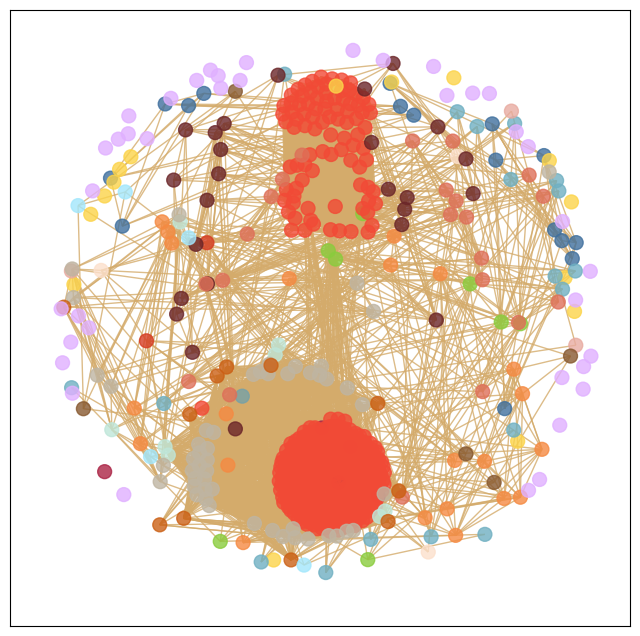

In [23]:
# Dibujar grafo
# Obtener los atributos para colorear los nodos
node_colors_bc = [cat_colores[G_bc.nodes[n]['act']] for n in G_bc.nodes()]


# Obtener las coordenadas para posicionar los nodos

node_positions_bc = nx.spring_layout(G_bc, k=0.7)

# Dibujar el grafo
nx.draw_networkx(G_bc, pos=node_positions_bc, 
                 width=1,
                 edge_color=color21,
                 node_size=100,
                 node_color=node_colors_bc,
                 alpha=0.8,
                 with_labels=False)

plt.savefig("img/red_bc.png")

# Mostrar el gráfico
plt.show()

### Ciudad de México

In [24]:
### Datos
data_cdmx = pd.read_csv(ruta_cdmx)
## Solamente nos quedamos con las columnas de datos necesarias
data_cdmx = data_cdmx[["nombre_act", "cve_mun", "municipio", "latitud", "longitud", "actividad"]]
## Generalizamos la codificación para que sea igual a nuestra matriz m1
data_cdmx.loc[data_cdmx['actividad'] == '46_1', 'actividad'] = '46'
data_cdmx.loc[data_cdmx['actividad'] == '46_2', 'actividad'] = '46'
data_cdmx.loc[data_cdmx['actividad'] == '46_3', 'actividad'] = '46'
data_cdmx.loc[data_cdmx['actividad'] == '72_1', 'actividad'] = '72'
data_cdmx.loc[data_cdmx['actividad'] == '81_1', 'actividad'] = '81'

## Añadimos el nombre de las actividades
data_cdmx = pd.merge(data_cdmx, dic_act, on='actividad')
data_cdmx

,nombre_act,cve_mun,municipio,latitud,longitud,actividad,nom_act
0,Distribución de energía eléctrica,15,Cuauhtémoc,19.424582,-99.176262,22,"Generación, transmisión y distribución de ener..."
1,Generación de electricidad a partir de combust...,3,Coyoacán,19.336428,-99.149620,22,"Generación, transmisión y distribución de ener..."
2,Comercialización de energía eléctrica,3,Coyoacán,19.335539,-99.197342,22,"Generación, transmisión y distribución de ener..."
3,Comercialización de energía eléctrica,15,Cuauhtémoc,19.424442,-99.176186,22,"Generación, transmisión y distribución de ener..."
4,Transmisión de energía eléctrica,10,Álvaro Obregón,19.339092,-99.214272,22,"Generación, transmisión y distribución de ener..."
...,...,...,...,...,...,...,...
2684,Impartición de justicia y mantenimiento de la ...,7,Iztapalapa,19.372549,-99.095329,93,"Actividades legislativas, gubernamentales, de ..."
2685,Regulación y fomento de actividades para mejor...,11,Tláhuac,19.281118,-99.050453,93,"Actividades legislativas, gubernamentales, de ..."
2686,Impartición de justicia y mantenimiento de la ...,7,Iztapalapa,19.351589,-99.047218,93,"Actividades legislativas, gubernamentales, de ..."
2687,Impartición de justicia y mantenimiento de la ...,3,Coyoacán,19.333611,-99.113548,93,"Actividades legislativas, gubernamentales, de ..."


In [25]:
# Observaciones
n_act_cdmx = data_cdmx['actividad'].value_counts()

# Porcentaje
per_act_cdmx = data_cdmx['actividad'].value_counts(normalize=True) * 100

# Crear data frame
data_act_cdmx = pd.DataFrame({'cuenta': n_act_cdmx, 'porcentaje': per_act_cdmx})

# Ordenar por observaciones
data_act_cdmx = data_act_cdmx.sort_values('cuenta', ascending=False)

# Mostrar
data_act_cdmx


,cuenta,porcentaje
56,493,18.333953
93,409,15.210115
54,271,10.078096
31-33,238,8.850874
43,164,6.098922
62,160,5.950167
61,156,5.801413
46,152,5.652659
52,152,5.652659
48-49,145,5.392339


In [26]:
### Calculamos distancia harvesine entre las empresas
# Convertimos las coordenadas de grados a radianes
coords_cdmx = data_cdmx[['latitud', 'longitud']].applymap(radians)

# Calculamos la matriz de distancias Haversine
dist_matrix_cdmx = haversine_distances(coords_cdmx)
m2_cdmx = pd.DataFrame(dist_matrix_cdmx)
m2_cdmx = m2_cdmx* 6371000/1000
m2_cdmx


,0,1,2,3,4,5,6,7,8,9,...,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688
0,0.000000,10.192859,10.145031,0.017489,10.308306,9.340435,3.412489,3.819804,11.273977,13.195321,...,3.440728,6.636774,4.753402,14.316120,3.915453,10.272751,20.704859,15.782328,12.066432,5.130129
1,10.192859,0.000000,5.008100,10.175703,6.789858,7.045214,13.018121,12.918338,17.620891,8.475311,...,7.190652,16.819887,13.389058,23.648021,14.106279,6.969450,12.088108,10.875233,3.797737,10.046800
2,10.145031,5.008100,0.000000,10.131582,1.819732,11.266463,11.868520,11.439503,20.049904,13.371102,...,8.506912,16.416013,14.501175,24.455921,13.764117,11.466262,16.559857,15.851481,8.794588,12.301748
3,0.017489,10.175703,10.131582,0.000000,10.297043,9.325418,3.427943,3.833143,11.276739,13.179993,...,3.423684,6.653654,4.759927,14.329099,3.932471,10.257403,20.687786,15.767493,12.049037,5.122091
4,10.308306,6.789858,1.819732,10.297043,0.000000,12.740107,11.520230,10.977673,20.794644,15.059408,...,9.254761,16.211652,14.895876,24.569444,13.655697,13.021080,18.359983,17.581765,10.585777,13.149945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,10.272751,6.969450,11.466262,10.257403,13.021080,1.004197,13.685076,14.034043,12.450114,2.922715,...,7.022795,15.747359,10.795017,20.187595,13.440666,0.000000,11.204179,5.559268,4.732840,6.662660
2685,20.704859,12.088108,16.559857,20.687786,18.359983,12.194075,24.011064,24.147868,22.968060,8.844876,...,17.264228,26.759531,21.978911,31.254875,24.287827,11.204179,0.000000,7.843367,8.826729,17.848308
2686,15.782328,10.875233,15.851481,15.767493,17.581765,6.446543,19.188034,19.568980,15.414485,2.709182,...,12.580380,20.871244,15.659640,24.042841,18.743056,5.559268,7.843367,0.000000,7.240673,11.662072
2687,12.066432,3.797737,8.794588,12.049037,10.585777,5.322999,15.283273,15.369225,16.954250,5.120823,...,8.661203,18.413330,14.126700,24.114845,15.814826,4.732840,8.826729,7.240673,0.000000,10.187764


In [27]:
# Vemos los estadísticos de las distancias
m2_cdmx.describe()

,0,1,2,3,4,5,6,7,8,9,...,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688
count,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,...,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000
mean,7.207766,9.947918,10.082900,7.203596,10.451392,10.264107,8.556335,8.663487,14.025305,13.008957,...,7.219740,11.137573,9.242238,17.759253,9.115786,10.824519,18.993376,15.285047,11.485413,8.567200
std,4.774463,4.207237,4.589820,4.769913,4.676775,3.920765,5.380084,5.316852,5.518276,4.405648,...,3.946244,5.922844,5.316832,6.332931,5.549492,4.014809,5.355004,4.670945,4.341737,4.436049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.327438,6.518468,7.033575,3.311564,6.760447,7.654370,4.598437,4.981956,10.087800,10.623737,...,3.931173,6.299093,4.844405,13.549121,4.234941,8.239747,16.216170,12.877042,8.273035,5.432704
50%,6.452863,10.267448,10.343167,6.445545,10.373846,9.791040,7.812299,7.988977,13.349584,12.710394,...,6.560137,10.125134,7.495921,16.854478,7.914630,10.330595,19.434832,15.112041,11.414716,8.008567
75%,10.467297,12.540923,12.362712,10.453655,13.112705,12.931053,11.819134,11.453890,17.956095,16.293938,...,10.245290,15.186143,12.971918,22.414062,12.978031,13.671118,23.490674,18.694700,15.024273,11.169017
max,31.044385,25.088783,25.861940,31.026983,27.188235,22.929267,34.227105,34.255465,33.636143,23.845547,...,27.634010,37.319403,32.681978,42.016774,34.768102,21.948388,32.623406,26.466683,25.543272,28.561981


In [28]:
### Creamos matriz que nos especifique si la distancia es poca entre las empresas
### Tomamos como cercanía que estén a menos de 10 km
m_cerca_cdmx = np.zeros((2689, 2689))

# Asignar 1 si el valor de la matriz original es 10 o menos
m_cerca_cdmx[(m2_cdmx <= 10) & (m2_cdmx > 0)] = 1
m_cerca_cdmx

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [29]:
### Creamos matriz que nos especifique si dos empresas tienen actividades que se relacionan
# Crea una matriz de ceros para las relaciones de datos
m_act_cdmx = np.zeros((2689,2689))



# Itera sobre todas las combinaciones posibles de filas en el data frame
for i in range(2689):
    for j in range(i+1, 2689):
        
        # Obtiene las actividades de las empresas i y j
        cat_i = data_cdmx.iloc[i]['actividad']
        cat_j = data_cdmx.iloc[j]['actividad']
        
        # Obtiene los índices correspondientes en la matriz de relaciones de actividades, m1
        idx_i = np.where(m1.columns == cat_i)[0][0]
        idx_j = np.where(m1.columns == cat_j)[0][0]
        
        # Establece el valor correspondiente en la matriz de relaciones de datos
        if m1.iloc[idx_i,idx_j] > 0:
            m_act_cdmx[i, j] = 1
            m_act_cdmx[j, i] = 1  # Como la matriz es simétrica, también establecemos la relación en la otra dirección

# Convierte la matriz resultante en un data frame
m_act_cdmx = pd.DataFrame(m_act_cdmx)
m_act_cdmx

,0,1,2,3,4,5,6,7,8,9,...,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
m_act_cdmx.describe()

,0,1,2,3,4,5,6,7,8,9,...,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688
count,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,...,2689.0,2689.0,2689.0,2689.0,2689.0,2689.0,2689.0,2689.0,2689.0,2689.0
mean,0.068799,0.068799,0.068799,0.068799,0.068799,0.068799,0.068799,0.068799,0.068799,0.068799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.253159,0.253159,0.253159,0.253159,0.253159,0.253159,0.253159,0.253159,0.253159,0.253159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
column_1000 = m_act_cdmx.iloc[:, 1001]
column_1000.describe()

In [31]:
### Enlazamos ahora las empresas en las que sus actividades productivas se relacionan y están a una distancia menor a 10km
edges_cdmx = m_act_cdmx.values * m_cerca_cdmx
pd.DataFrame(edges_cdmx)

,0,1,2,3,4,5,6,7,8,9,...,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688
0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creación de red

In [32]:
# Crear grafo vacío
G_cdmx = nx.Graph()

# Agregar nodos con sus atributos
for i in range(2689):
    act = data_cdmx.loc[i, "actividad"]
    lat = data_cdmx.loc[i, "latitud"]
    lon = data_cdmx.loc[i, "longitud"]
    G_cdmx.add_node(i, act=act, lat=lat, lon=lon)

# Agregar conexiones
for i in range(2689):
    for j in range(2689):
        if edges_cdmx[i][j] == 1:
            G_cdmx.add_edge(i, j)
            


In [33]:
## Revisar que se haya definido correctamente            
print(list(G_cdmx.nodes)[0:20])
print(list(G_cdmx.edges)[10000:10020])
atributos_nodo_cdmx = G_cdmx.nodes[1000]
print(atributos_nodo_cdmx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[(169, 187), (169, 188), (169, 191), (169, 192), (169, 193), (169, 195), (169, 196), (169, 197), (169, 198), (169, 199), (169, 200), (169, 204), (169, 206), (169, 207), (169, 210), (169, 215), (169, 216), (169, 217), (169, 219), (169, 222)]
{'act': '52', 'lat': 19.349758, 'lon': -99.184135}


C:\Users\zyany\anaconda3\envs\proyecto_redes\lib\site-packages\matplotlib\cbook\__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


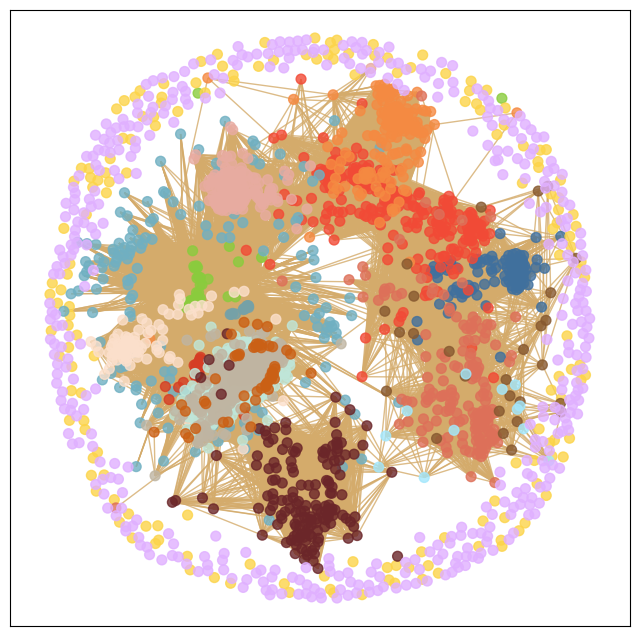

In [34]:
# Dibujar grafo
# Obtener los atributos para colorear los nodos
node_colors_cdmx = [cat_colores[G_cdmx.nodes[n]['act']] for n in G_cdmx.nodes()]


# Obtener las coordenadas para posicionar los nodos
node_positions_cdmx = nx.spring_layout(G_cdmx, k=0.3)

# Dibujar el grafo
nx.draw_networkx(G_cdmx, pos=node_positions_cdmx, 
                 width=1,
                 edge_color=color21,
                 node_size=50,
                 node_color=node_colors_cdmx,
                 alpha=0.8,
                 with_labels=False)

plt.savefig("img/red_cdmx.png")

# Mostrar el gráfico
plt.show()

### Veracruz

In [44]:
### Datos
data_v = pd.read_csv(ruta_v)
## Solamente nos quedamos con las columnas de datos necesarias
data_v = data_v[["nombre_act", "cve_mun", "municipio", "latitud", "longitud", "actividad"]]
## Generalizamos la codificación para que sea igual a nuestra matriz m1
data_v.loc[data_v['actividad'] == '46_1', 'actividad'] = '46'
data_v.loc[data_v['actividad'] == '46_2', 'actividad'] = '46'
data_v.loc[data_v['actividad'] == '46_3', 'actividad'] = '46'
data_v.loc[data_v['actividad'] == '72_1', 'actividad'] = '72'
data_v.loc[data_v['actividad'] == '81_1', 'actividad'] = '81'

## Añadimos el nombre de las actividades
data_v = pd.merge(data_v, dic_act, on='actividad')
data_v


,nombre_act,cve_mun,municipio,latitud,longitud,actividad,nom_act
0,"Pesca y captura de peces, crustáceos, moluscos...",151,Tamiahua,21.273035,-97.445030,11,"Agricultura, cría y explotación de animales, a..."
1,"Pesca y captura de peces, crustáceos, moluscos...",151,Tamiahua,21.278759,-97.446045,11,"Agricultura, cría y explotación de animales, a..."
2,Generación de electricidad a partir de combust...,105,Medellín,19.083933,-96.144882,22,"Generación, transmisión y distribución de ener..."
3,Generación de electricidad a partir de combust...,39,Coatzacoalcos,18.144087,-94.424393,22,"Generación, transmisión y distribución de ener..."
4,"Captación, tratamiento y suministro de agua re...",108,Minatitlán,17.992996,-94.577728,22,"Generación, transmisión y distribución de ener..."
...,...,...,...,...,...,...,...
384,Actividades administrativas de instituciones d...,87,Xalapa,19.510195,-96.929489,93,"Actividades legislativas, gubernamentales, de ..."
385,Actividades administrativas de instituciones d...,87,Xalapa,19.528006,-96.920746,93,"Actividades legislativas, gubernamentales, de ..."
386,Impartición de justicia y mantenimiento de la ...,87,Xalapa,19.526541,-96.921577,93,"Actividades legislativas, gubernamentales, de ..."
387,Impartición de justicia y mantenimiento de la ...,87,Xalapa,19.538416,-96.908005,93,"Actividades legislativas, gubernamentales, de ..."


In [36]:
# Observaciones
n_act_v = data_v['actividad'].value_counts()

# Porcentaje
per_act_v = data_v['actividad'].value_counts(normalize=True) * 100

# Crear data frame
data_act_v = pd.DataFrame({'cuenta': n_act_v, 'porcentaje': per_act_v})

# Ordenar por observaciones
data_act_v = data_act_v.sort_values('cuenta', ascending=False)

# Mostrar
data_act_v


,cuenta,porcentaje
93,98,25.192802
31-33,85,21.850900
62,51,13.110540
48-49,27,6.940874
43,24,6.169666
46,24,6.169666
22,20,5.141388
23,18,4.627249
61,17,4.370180
56,15,3.856041


In [37]:
### Calculamos distancia harvesine entre las empresas
# Convertimos las coordenadas de grados a radianes
coords_v = data_v[['latitud', 'longitud']].applymap(radians)

# Calculamos la matriz de distancias Haversine
dist_matrix_v = haversine_distances(coords_v)
m2_v = pd.DataFrame(dist_matrix_v)
m2_v = m2_v* 6371000/1000
m2_v


,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,0.000000,0.645110,278.679320,470.104527,472.402033,115.294382,199.695226,469.612899,269.981852,271.083123,...,37.446625,272.768026,274.611277,200.403449,267.437206,203.249402,201.584284,201.717722,200.835759,264.777080
1,0.645110,0.000000,279.285680,470.643212,472.957560,114.744633,200.335913,470.151408,270.626639,271.683757,...,38.090221,273.412714,275.211809,201.044784,268.038225,203.890945,202.225340,202.358824,201.476222,265.379409
2,278.679320,279.285680,0.000000,209.262553,204.965346,392.337130,95.936105,208.867180,87.018998,10.272838,...,242.907224,105.628001,8.164624,96.624007,12.947810,95.009791,95.223609,95.214194,94.693404,14.728113
3,470.104527,470.643212,209.262553,0.000000,23.345209,585.346024,305.114981,0.543967,278.606489,212.493031,...,437.880630,294.133682,209.309765,305.853183,215.937058,304.270970,304.458031,304.452213,303.883725,218.987722
4,472.402033,472.957560,204.965346,23.345209,0.000000,587.685196,300.782104,23.618324,269.089787,209.249819,...,439.243385,283.799574,205.917677,301.383939,212.811935,299.621499,299.972745,299.952952,299.526918,215.832865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,203.249402,203.890945,95.009791,304.270970,299.621499,311.333700,4.296730,303.874736,68.927087,92.464020,...,165.832945,77.086725,95.418749,2.911476,89.264881,0.000000,2.182194,1.997810,3.862217,86.240464
385,201.584284,202.225340,95.223609,304.458031,299.972745,309.912793,2.140475,304.059142,70.936408,92.447177,...,164.180615,79.235936,95.445981,1.420093,89.205648,2.182194,0.000000,0.184719,1.767103,86.171838
386,201.717722,202.358824,95.214194,304.452213,299.952952,310.024444,2.318711,304.053549,70.770307,92.457240,...,164.312798,79.056062,95.452380,1.471477,89.219221,1.997810,0.184719,0.000000,1.940739,86.186132
387,200.835759,201.476222,94.693404,303.883725,299.526918,309.423549,1.283445,303.482809,72.156289,91.742329,...,163.449403,80.705599,94.773062,2.422315,88.470524,3.862217,1.767103,1.940739,0.000000,85.430976


In [38]:
# Vemos los estadísticos de las distancias
m2_v.describe()

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,...,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,260.409414,260.983896,114.395622,248.667813,244.983656,364.873847,115.070891,248.372725,124.678118,113.266207,...,227.428860,134.910060,114.393450,115.251479,112.400431,114.637709,114.580293,114.575506,114.495389,111.769342
std,115.532588,115.564470,87.499067,129.615003,129.074728,129.107705,101.108119,129.427329,95.241808,87.932754,...,112.783711,96.250501,87.523781,101.379829,88.034325,101.173759,101.289284,101.295106,101.013726,87.948749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201.440035,202.080929,64.878654,212.068098,208.592268,309.716871,55.513378,211.659467,70.526492,68.377523,...,164.040935,79.092416,71.893472,56.972910,64.766284,56.281961,55.731715,55.785452,54.667306,62.229845
50%,267.130037,267.732837,95.236888,275.820527,266.564145,375.259845,87.559805,275.515700,89.210198,92.870741,...,231.581081,107.289361,95.630667,88.324869,90.240653,86.388919,86.936340,86.935244,86.332072,87.827901
75%,274.718985,275.320553,200.387833,304.470325,300.088511,388.063015,164.104671,304.071377,190.179300,203.536981,...,239.211234,195.094737,201.231200,164.754416,201.100003,167.580060,165.959709,166.088993,165.264403,198.169237
max,513.269161,513.801548,401.177092,589.832581,593.152696,628.439704,348.957730,589.330071,388.382768,393.543972,...,481.359114,389.181660,397.070879,349.674401,389.902217,348.060613,348.276041,348.267889,347.722275,387.254234


In [39]:
### Creamos matriz que nos especifique si la distancia es poca entre las empresas
### Tomamos como cercanía que estén a menos de 100 km
m_cerca_v = np.zeros((389, 389))

# Asignar 1 si el valor de la matriz original es 10 o menos
m_cerca_v[(m2_v <= 100) & (m2_v > 0)] = 1
m_cerca_v

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]])

In [40]:
### Creamos matriz que nos especifique si dos empresas tienen actividades que se relacionan
# Crea una matriz de ceros para las relaciones de datos
m_act_v = np.zeros((389,389))



# Itera sobre todas las combinaciones posibles de filas en el data frame
for i in range(389):
    for j in range(i+1, 389):
        
        # Obtiene las actividades de las empresas i y j
        cat_i = data_v.iloc[i]['actividad']
        cat_j = data_v.iloc[j]['actividad']
        
        # Obtiene los índices correspondientes en la matriz de relaciones de actividades, m1
        idx_i = np.where(m1.columns == cat_i)[0][0]
        idx_j = np.where(m1.columns == cat_j)[0][0]
        
        # Establece el valor correspondiente en la matriz de relaciones de datos
        if m1.iloc[idx_i,idx_j] > 0:
            m_act_v[i, j] = 1
            m_act_v[j, i] = 1  # Como la matriz es simétrica, también establecemos la relación en la otra dirección

# Convierte la matriz resultante en un data frame
m_act_v = pd.DataFrame(m_act_v)
m_act_v


,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
### Enlazamos ahora las empresas en las que sus actividades productivas se relacionan y están a una distancia menor a 100km
edges_v = m_act_v.values * m_cerca_v
pd.DataFrame(edges_v)


,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creación de la red

In [42]:
# Crear grafo vacío
G_v = nx.Graph()

# Agregar nodos con sus atributos
for i in range(389):
    act = data_v.loc[i, "actividad"]
    lat = data_v.loc[i, "latitud"]
    lon = data_v.loc[i, "longitud"]
    G_v.add_node(i, act=act, lat=lat, lon=lon)

# Agregar conexiones
for i in range(389):
    for j in range(389):
        if edges_v[i][j] == 1:
            G_v.add_edge(i, j)


C:\Users\zyany\anaconda3\envs\proyecto_redes\lib\site-packages\matplotlib\cbook\__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


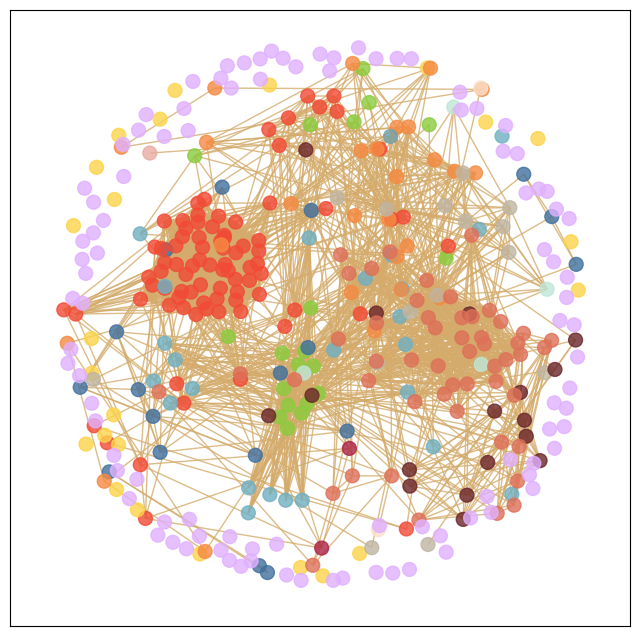

In [43]:
# Dibujar grafo
# Obtener los atributos para colorear los nodos
node_colors_v = [cat_colores[G_v.nodes[n]['act']] for n in G_v.nodes()]


# Obtener las coordenadas para posicionar los nodos

node_positions_v = nx.spring_layout(G_v, k=0.7)

# Dibujar el grafo
nx.draw_networkx(G_v, pos=node_positions_v, 
                 width=1,
                 edge_color=color21,
                 node_size=100,
                 node_color=node_colors_v,
                 alpha=0.8,
                 with_labels=False)
plt.savefig("img/red_v.png")
# Mostrar el gráfico
plt.show()


## Análisis de centralidad

### Baja California

In [45]:
# Crear un diccionario con los atributos de los nodos
node_dict = dict(G_bc.nodes(data=True))

# Crear un diccionario para cada medida de centralidad
bc_dict_bc = nx.betweenness_centrality(G_bc)
cc_dict_bc = nx.closeness_centrality(G_bc)
ec_dict_bc = nx.eigenvector_centrality(G_bc)
dc_dict_bc = nx.degree_centrality(G_bc)
cluster_dict_bc = nx.clustering(G_bc)
avg_neighbor_degree_dict_bc = nx.average_neighbor_degree(G_bc)

# Crear un DataFrame con las medidas de centralidad y estadísticas descriptivas
df_bc = pd.DataFrame({'grado':  pd.Series(dict(G_bc.degree())),
                   'betweenness': pd.Series(bc_dict_bc),
                   'closeness': pd.Series(cc_dict_bc),
                   'eigenvector': pd.Series(ec_dict_bc),
                   'degree_centrality': pd.Series(dc_dict_bc),
                   'cluster_coefficient': pd.Series(cluster_dict_bc),
                    'avg_neighbor_degree': pd.Series(avg_neighbor_degree_dict_bc),   
                   'act': pd.Series(nx.get_node_attributes(G_bc, 'act'))})

# Ordenar el DataFrame por la columna de grado y seleccionar las primeras 50 filas
df_bc_sorted = df_bc.sort_values(by='degree_centrality', ascending=False)

# Renombrar columna para poder hacer merge
df_bc_sorted = df_bc_sorted.rename(columns={'act': 'actividad'})

# Añadimos los nombres de las actividades
df_bc_sorted = pd.merge(df_bc_sorted, dic_act, on='actividad')


# Guardar el archivo en excel
df_bc_sorted.to_excel("tabla/bc_estadisticos.xlsx", index=False)

In [47]:
# Hacemos una tabla con el top y el bottom 5

# Crear un dataframe con las primeras 5 observaciones
df_bc_top = df_bc_sorted.head(5)

# Crear un dataframe con las últimas 5 observaciones
df_bc_bottom = df_bc_sorted.tail(5)

# Concatenar los dos dataframes
df_bc_sum = pd.concat([df_bc_top, df_bc_bottom])


# Guardar el archivo en excel
df_bc_sum.to_excel("tabla/bc_topbot.xlsx", index=False)

# Imprimir el nuevo dataframe
df_bc_sum


,grado,betweenness,closeness,eigenvector,degree_centrality,cluster_coefficient,avg_neighbor_degree,actividad,nom_act
0,302,0.022034,0.495332,5.825719e-02,0.471875,0.94900,288.943709,31-33,Industrias manufactureras
1,302,0.022034,0.495332,5.825719e-02,0.471875,0.94900,288.943709,31-33,Industrias manufactureras
2,302,0.022034,0.495332,5.825719e-02,0.471875,0.94900,288.943709,31-33,Industrias manufactureras
3,297,0.007680,0.490118,5.824630e-02,0.464063,0.98048,292.259259,31-33,Industrias manufactureras
4,297,0.007680,0.490118,5.824630e-02,0.464063,0.98048,292.259259,31-33,Industrias manufactureras
636,0,0.000000,0.000000,3.439248e-24,0.000000,0.00000,0.000000,43,Comercio al por mayor
637,0,0.000000,0.000000,3.439248e-24,0.000000,0.00000,0.000000,43,Comercio al por mayor
638,0,0.000000,0.000000,3.439248e-24,0.000000,0.00000,0.000000,43,Comercio al por mayor
639,0,0.000000,0.000000,3.439248e-24,0.000000,0.00000,0.000000,43,Comercio al por mayor
640,0,0.000000,0.000000,3.439248e-24,0.000000,0.00000,0.000000,43,Comercio al por mayor


In [49]:
# Finalmente hacemos un análisis por tipo de actividad
df_grouped_bc = df_bc_sorted.groupby('actividad')
df_stats_bc = df_grouped_bc.mean()
# Añadimos los nombres de las actividades
df_stats_bc = pd.merge(df_stats_bc, dic_act, on='actividad')
df_stats_bc

C:\Users\zyany\AppData\Local\Temp\ipykernel_2452\1570134545.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stats_bc = df_grouped_bc.mean()


,actividad,grado,betweenness,closeness,eigenvector,degree_centrality,cluster_coefficient,avg_neighbor_degree,nom_act
0,11,235.400000,4.812915e-05,0.332137,4.647704e-02,0.367812,0.795003,234.660344,"Agricultura, cría y explotación de animales, a..."
1,22,13.500000,4.997433e-05,0.021208,1.400401e-14,0.021094,0.325000,6.875000,"Generación, transmisión y distribución de ener..."
2,23,7.125000,0.000000e+00,0.011133,8.102137e-16,0.011133,1.000000,7.125000,Construcción
3,31-33,245.125326,6.419748e-04,0.379192,4.428727e-02,0.383008,0.996517,245.939171,Industrias manufactureras
4,43,0.000000,0.000000e+00,0.000000,3.439248e-24,0.000000,0.000000,0.000000,Comercio al por mayor
5,46,4.666667,8.829986e-07,0.012878,6.962229e-15,0.007292,0.533333,12.666667,Comercio al por menor
6,48-49,10.363636,0.000000e+00,0.016193,2.209643e-14,0.016193,1.000000,10.363636,"Transportes, correos y almacenamiento"
7,51,4.000000,0.000000e+00,0.032640,4.220586e-11,0.006250,1.000000,7.000000,Información en medios masivos
8,52,1.333333,0.000000e+00,0.028711,1.369936e-10,0.002083,0.666667,17.666667,Servicios financieros y de seguros
9,53,10.000000,4.345660e-04,0.047340,1.048800e-09,0.015625,0.266667,27.300000,Servicios inmobiliarios y de alquiler de biene...


In [52]:
# Para guardar la tabla
# Guardar el archivo en excel
df_stats_bc.to_excel("tabla/bc_statsact.xlsx", index=False)


PermissionError: [Errno 13] Permission denied: 'tabla/bc_statsact.xlsx'

### Ciudad de México

In [53]:
# Crear un diccionario con los atributos de los nodos
node_dict = dict(G_cdmx.nodes(data=True))

# Crear un diccionario para cada medida de centralidad
cdmx_dict_cdmx = nx.betweenness_centrality(G_cdmx)
cc_dict_cdmx = nx.closeness_centrality(G_cdmx)
ec_dict_cdmx = nx.eigenvector_centrality(G_cdmx)
dc_dict_cdmx = nx.degree_centrality(G_cdmx)
cluster_dict_cdmx = nx.clustering(G_cdmx)
avg_neighbor_degree_dict_cdmx = nx.average_neighbor_degree(G_cdmx)

# Crear un DataFrame con las medidas de centralidad y estadísticas descriptivas
df_cdmx = pd.DataFrame({'grado':  pd.Series(dict(G_cdmx.degree())),
                   'betweenness': pd.Series(cdmx_dict_cdmx),
                   'closeness': pd.Series(cc_dict_cdmx),
                   'eigenvector': pd.Series(ec_dict_cdmx),
                   'degree_centrality': pd.Series(dc_dict_cdmx),
                   'cluster_coefficient': pd.Series(cluster_dict_cdmx),
                    'avg_neighbor_degree': pd.Series(avg_neighbor_degree_dict_cdmx),   
                   'act': pd.Series(nx.get_node_attributes(G_cdmx, 'act'))})

# Ordenar el DataFrame por la columna de grado y seleccionar las primeras 50 filas
df_cdmx_sorted = df_cdmx.sort_values(by='degree_centrality', ascending=False)

# Renombrar columna para poder hacer merge
df_cdmx_sorted = df_cdmx_sorted.rename(columns={'act': 'actividad'})

# Añadimos los nombres de las actividades
df_cdmx_sorted = pd.merge(df_cdmx_sorted, dic_act, on='actividad')


# Guardar el archivo en excel
df_cdmx_sorted.to_excel("tabla/cdmx_estadisticos.xlsx", index=False)


In [54]:
# Hacemos una tabla con el top y el bottom 5

# Crear un dataframe con las primeras 5 observaciones
df_cdmx_top = df_cdmx_sorted.head(5)

# Crear un dataframe con las últimas 5 observaciones
df_cdmx_bottom = df_cdmx_sorted.tail(5)

# Concatenar los dos dataframes
df_cdmx_sum = pd.concat([df_cdmx_top, df_cdmx_bottom])


# Guardar el archivo en excel
df_cdmx_sum.to_excel("tabla/cdmx_topbot.xlsx", index=False)

# Imprimir el nuevo dataframe
df_cdmx_sum


,grado,betweenness,closeness,eigenvector,degree_centrality,cluster_coefficient,avg_neighbor_degree,actividad,nom_act
0,754,0.000300,0.291880,4.639511e-02,0.280506,0.641635,516.183024,56,Servicios de apoyo a los negocios y manejo de ...
1,748,0.000273,0.290722,4.611671e-02,0.278274,0.643952,517.066845,56,Servicios de apoyo a los negocios y manejo de ...
2,748,0.000273,0.290722,4.611671e-02,0.278274,0.643952,517.066845,56,Servicios de apoyo a los negocios y manejo de ...
3,748,0.000273,0.290722,4.609535e-02,0.278274,0.643372,516.803476,56,Servicios de apoyo a los negocios y manejo de ...
4,744,0.000310,0.289955,4.559389e-02,0.276786,0.638479,514.668011,56,Servicios de apoyo a los negocios y manejo de ...
2684,0,0.000000,0.000000,7.362601e-27,0.000000,0.000000,0.000000,43,Comercio al por mayor
2685,0,0.000000,0.000000,7.362601e-27,0.000000,0.000000,0.000000,43,Comercio al por mayor
2686,0,0.000000,0.000000,7.362601e-27,0.000000,0.000000,0.000000,43,Comercio al por mayor
2687,0,0.000000,0.000000,7.362601e-27,0.000000,0.000000,0.000000,43,Comercio al por mayor
2688,0,0.000000,0.000000,7.362601e-27,0.000000,0.000000,0.000000,43,Comercio al por mayor


In [55]:
# Finalmente hacemos un análisis por tipo de actividad
df_grouped_cdmx = df_cdmx_sorted.groupby('actividad')
df_stats_cdmx = df_grouped_cdmx.mean()
# Añadimos los nombres de las actividades
df_stats_cdmx = pd.merge(df_stats_cdmx, dic_act, on='actividad')
df_stats_cdmx

# Para guardar la tabla
# Guardar el archivo en excel
df_stats_cdmx.to_excel("tabla/cdmx_statsact.xlsx", index=False)


C:\Users\zyany\AppData\Local\Temp\ipykernel_2452\3001273193.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stats_cdmx = df_grouped_cdmx.mean()


### Veracruz

In [56]:
# Crear un diccionario con los atributos de los nodos
node_dict = dict(G_v.nodes(data=True))

# Crear un diccionario para cada medida de centralidad
v_dict_v = nx.betweenness_centrality(G_v)
cc_dict_v = nx.closeness_centrality(G_v)
ec_dict_v = nx.eigenvector_centrality(G_v)
dc_dict_v = nx.degree_centrality(G_v)
cluster_dict_v = nx.clustering(G_v)
avg_neighbor_degree_dict_v = nx.average_neighbor_degree(G_v)

# Crear un DataFrame con las medidas de centralidad y estadísticas descriptivas
df_v = pd.DataFrame({'grado':  pd.Series(dict(G_v.degree())),
                   'betweenness': pd.Series(v_dict_v),
                   'closeness': pd.Series(cc_dict_v),
                   'eigenvector': pd.Series(ec_dict_v),
                   'degree_centrality': pd.Series(dc_dict_v),
                   'cluster_coefficient': pd.Series(cluster_dict_v),
                    'avg_neighbor_degree': pd.Series(avg_neighbor_degree_dict_v),   
                   'act': pd.Series(nx.get_node_attributes(G_v, 'act'))})

# Ordenar el DataFrame por la columna de grado y seleccionar las primeras 50 filas
df_v_sorted = df_v.sort_values(by='degree_centrality', ascending=False)

# Renombrar columna para poder hacer merge
df_v_sorted = df_v_sorted.rename(columns={'act': 'actividad'})

# Añadimos los nombres de las actividades
df_v_sorted = pd.merge(df_v_sorted, dic_act, on='actividad')


# Guardar el archivo en excel
df_v_sorted.to_excel("tabla/v_estadisticos.xlsx", index=False)


In [57]:
# Hacemos una tabla con el top y el bottom 5

# Crear un dataframe con las primeras 5 observaciones
df_v_top = df_v_sorted.head(5)

# Crear un dataframe con las últimas 5 observaciones
df_v_bottom = df_v_sorted.tail(5)

# Concatenar los dos dataframes
df_v_sum = pd.concat([df_v_top, df_v_bottom])


# Guardar el archivo en excel
df_v_sum.to_excel("tabla/v_topbot.xlsx", index=False)

# Imprimir el nuevo dataframe
df_v_sum


,grado,betweenness,closeness,eigenvector,degree_centrality,cluster_coefficient,avg_neighbor_degree,actividad,nom_act
0,56,0.000209,0.119517,1.421620e-01,0.14433,0.881169,50.517857,31-33,Industrias manufactureras
1,56,0.000209,0.119517,1.421620e-01,0.14433,0.881169,50.517857,31-33,Industrias manufactureras
2,56,0.000209,0.119517,1.421620e-01,0.14433,0.881169,50.517857,31-33,Industrias manufactureras
3,56,0.001161,0.124676,1.381144e-01,0.14433,0.835065,49.250000,31-33,Industrias manufactureras
4,56,0.000209,0.119517,1.421620e-01,0.14433,0.881169,50.517857,31-33,Industrias manufactureras
384,0,0.000000,0.000000,2.236056e-27,0.00000,0.000000,0.000000,43,Comercio al por mayor
385,0,0.000000,0.000000,2.236056e-27,0.00000,0.000000,0.000000,43,Comercio al por mayor
386,0,0.000000,0.000000,2.236056e-27,0.00000,0.000000,0.000000,43,Comercio al por mayor
387,0,0.000000,0.000000,2.236056e-27,0.00000,0.000000,0.000000,43,Comercio al por mayor
388,0,0.000000,0.000000,2.236056e-27,0.00000,0.000000,0.000000,43,Comercio al por mayor


In [58]:
# Finalmente hacemos un análisis por tipo de actividad
df_grouped_v = df_v_sorted.groupby('actividad')
df_stats_v = df_grouped_v.mean()
# Añadimos los nombres de las actividades
df_stats_v = pd.merge(df_stats_v, dic_act, on='actividad')
df_stats_v

# Para guardar la tabla
# Guardar el archivo en excel
df_stats_v.to_excel("tabla/v_statsact.xlsx", index=False)


C:\Users\zyany\AppData\Local\Temp\ipykernel_2452\3657361971.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stats_v = df_grouped_v.mean()


## Distribución de grado

### Baja California

In [ ]:
# Obtener los grados de los nodos
degrees = dict(G_bc.degree())

# Hacer el histograma de los grados
plt.hist(list(dict(G_bc.degree()).values()), bins=range(0, 100, 5), color=color21)


# Añadir títulos y etiquetas
plt.title("Distribución de grado en la red de Baja California")
plt.xlabel("Grado")
plt.ylabel("Número de nodos")

plt.savefig("img/bc_dg_ds.png")

# Mostrar el gráfico
plt.show()


### Ciudad de México

In [ ]:
# Obtener los grados de los nodos
degrees = dict(G_cdmx.degree())

# Hacer el histograma de los grados
plt.hist(list(dict(G_cdmx.degree()).values()), bins=range(0, 100, 5), color=color21)


# Añadir títulos y etiquetas
plt.title("Distribución de grado en la red de CDMX")
plt.xlabel("Grado")
plt.ylabel("Número de nodos")

plt.savefig("img/cdmx_dg_ds.png")

# Mostrar el gráfico
plt.show()


### Veracruz

In [ ]:
# Obtener los grados de los nodos
degrees = dict(G_v.degree())

# Hacer el histograma de los grados
plt.hist(list(dict(G_v.degree()).values()), bins=range(0, 100, 5), color=color21)


# Añadir títulos y etiquetas
plt.title("Distribución de grado en la red de Veracruz")
plt.xlabel("Grado")
plt.ylabel("Número de nodos")

plt.savefig("img/v_dg_ds.png")

# Mostrar el gráfico
plt.show()


## Porcentaje de actividad económica

### Baja California

In [ ]:

# # Crear el dataframe con las variables que se quieren incluir en el treemap
# df_act_bc = pd.DataFrame(data_bc.groupby(['actividad', 'nom_act']).size(), columns=['count']).reset_index()

# # Agregar una columna con el porcentaje de cada actividad
# df_act_bc['percentage'] = df_act_bc['count'] / df_act_bc['count'].sum()

# # Crear una lista de porcentajes para etiquetar el treemap
# Label_per_bc = [f"{i:.1%}" for i in df_act['percentage']]

# # Crear el treemap
# fig_bc = px.treemap(df_act, path=[px.Constant('Actividades'), 'nom_act', 'actividad'],
#                  values='count',
#                  color='actividad',
#                  color_discrete_map=cat_colores,
#                  hover_name=Label_per)

# # Configurar el diseño del treemap
# fig_bc.update_layout(margin = dict(t=50, l=25, r=25, b=25), showlegend=True)

# # Mostrar el treemap
# fig_bc.show()

# # Guardar el treemap como una imagen
# fig.write_image("bc_treemap.png", format="png")


In [ ]:
# Creamos un dataframe que agrupe por actividad y nom_act y calcule el porcentaje correspondiente
df_bc_porcentajes = data_bc.groupby(['actividad', 'nom_act']).size().reset_index(name='num_obs')
df_bc_porcentajes['porcentaje'] = round(
    df_bc_porcentajes['num_obs'] *100/ df_bc_porcentajes['num_obs'].sum(),2)


# Filtrar las observaciones con porcentaje mayor al 5%
df_bc_porcentajes_filtro = df_bc_porcentajes[df_bc_porcentajes['porcentaje'] > 2]

# Ordenamos por tamaño
df_bc_porcentajes_filtro = df_bc_porcentajes_filtro.sort_values(by='num_obs', ascending=False)


# Usamos circlify para generar los tamaños de los círculos según los porcentajes
circles_bc = circlify.circlify(df_bc_porcentajes_filtro['porcentaje'].tolist(), 
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))
circles_bc.reverse()


# Etiquetas para cada círculo
label_bc = [i+'<br>'+str(j)+'<br>'+str(k)+'%' for i,j,k in zip(df_bc_porcentajes_filtro.actividad,
                                                            df_bc_porcentajes_filtro.num_obs,
                                                            df_bc_porcentajes_filtro.porcentaje)]

# Área de gráfico
fig, ax = plt.subplots(figsize=(14,14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles_bc)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Poner círculos
for circle, note in zip(circles_bc, label_bc):
    x, y, r = circle
    actividad = note.split('<br>')[0]  # obtener la actividad a partir de la etiqueta
    color = cat_colores.get(actividad, 'gray')  # obtener el color correspondiente o usar gris como predeterminado
    ax.add_patch(plt.Circle((x, y), r, alpha=1, color=color))
    plt.annotate(note.replace('<br>', '\n'), (x, y), size=16, va='center', ha='center')

plt.xticks([])
plt.yticks([])

plt.title("Especialización de empresas en Baja California",  fontsize=20)

# Guardar imagen
plt.savefig("img/bc_per.png")

# Mostrar imagen
plt.show()

### Ciudad de México

In [ ]:
# Creamos un dataframe que agrupe por actividad y nom_act y calcule el porcentaje correspondiente
df_cdmx_porcentajes = data_cdmx.groupby(['actividad', 'nom_act']).size().reset_index(name='num_obs')
df_cdmx_porcentajes['porcentaje'] = round(
    df_cdmx_porcentajes['num_obs'] *100/ df_cdmx_porcentajes['num_obs'].sum(),2)

# Filtrar las observaciones con porcentaje mayor al 5%
df_cdmx_porcentajes_filtro = df_cdmx_porcentajes[df_cdmx_porcentajes['porcentaje'] > 2.5]


# Ordenamos por tamaño
df_cdmx_porcentajes_filtro = df_cdmx_porcentajes_filtro.sort_values(by='num_obs', ascending=False)

# Usamos circlify para generar los tamaños de los círculos según los porcentajes
circles_cdmx = circlify.circlify(df_cdmx_porcentajes_filtro['porcentaje'].tolist(), 
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))
circles_cdmx.reverse()


# Etiquetas para cada círculo
label_cdmx = [i+'<br>'+str(j)+'<br>'+str(k)+'%' for i,j,k in zip(df_cdmx_porcentajes_filtro.actividad,
                                                            df_cdmx_porcentajes_filtro.num_obs,
                                                            df_cdmx_porcentajes_filtro.porcentaje)]

# Área de gráfico
fig, ax = plt.subplots(figsize=(14,14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles_cdmx)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Poner círculos
for circle, note in zip(circles_cdmx, label_cdmx):
    x, y, r = circle
    actividad = note.split('<br>')[0]  # obtener la actividad a partir de la etiqueta
    color = cat_colores.get(actividad, 'gray')  # obtener el color correspondiente o usar gris como predeterminado
    ax.add_patch(plt.Circle((x, y), r, alpha=1, color=color))
    plt.annotate(note.replace('<br>', '\n'), (x, y), size=16, va='center', ha='center')

plt.xticks([])
plt.yticks([])

plt.title("Especialización de empresas en CDMX",  fontsize=20)

# Guardar imagen
plt.savefig("img/cdmx_per.png")

# Mostrar imagen
plt.show()


#### Veracruz

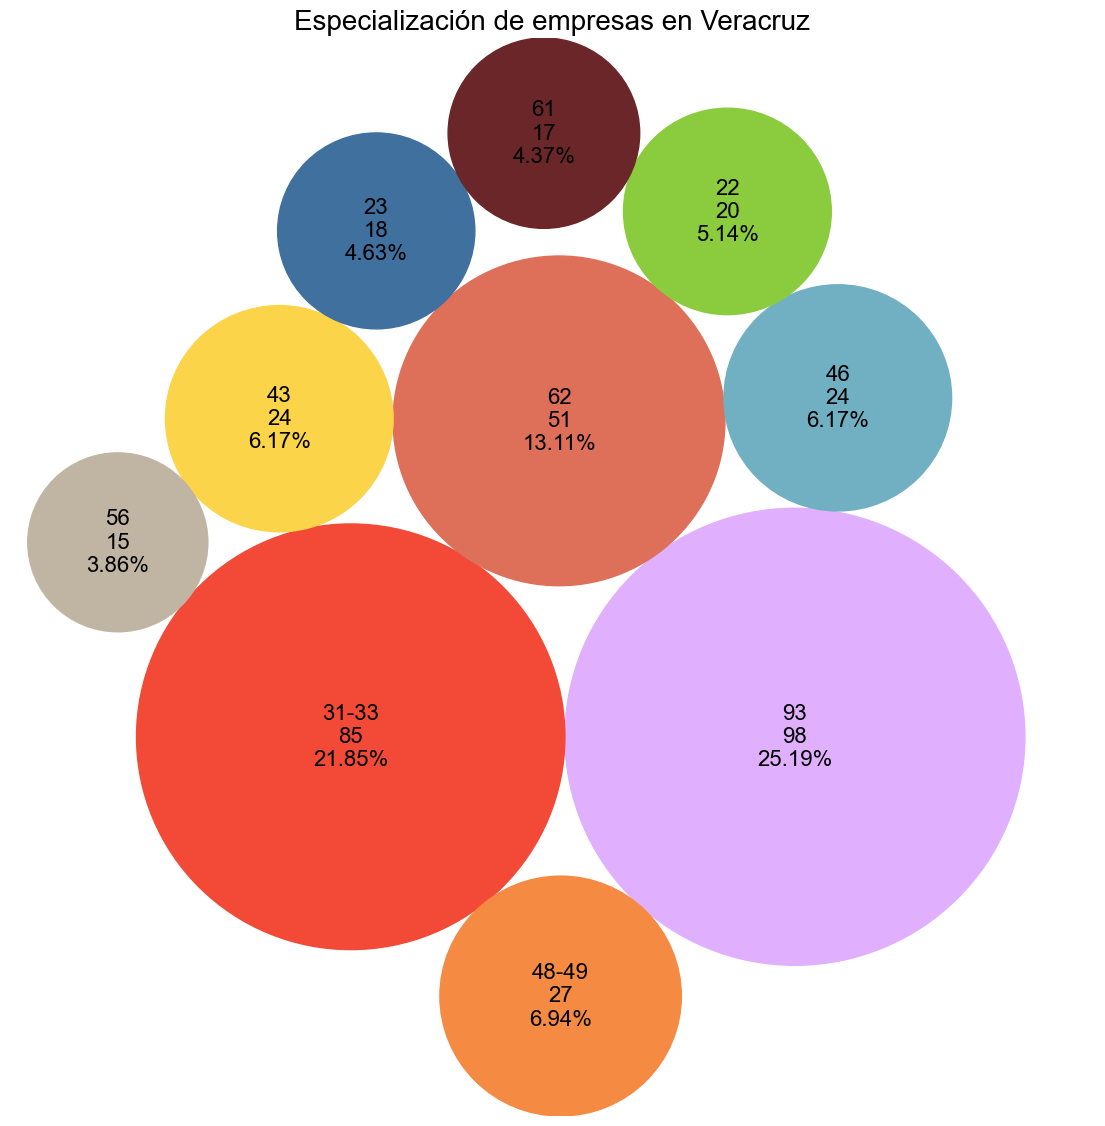

In [59]:
# Creamos un dataframe que agrupe por actividad y nom_act y calcule el porcentaje correspondiente
df_v_porcentajes = data_v.groupby(['actividad', 'nom_act']).size().reset_index(name='num_obs')
df_v_porcentajes['porcentaje'] = round(
    df_v_porcentajes['num_obs'] *100/ df_v_porcentajes['num_obs'].sum(),2)

# Filtrar las observaciones con porcentaje mayor al 5%
df_v_porcentajes_filtro = df_v_porcentajes[df_v_porcentajes['porcentaje'] > 2.5]


# Ordenamos por tamaño
df_v_porcentajes_filtro = df_v_porcentajes_filtro.sort_values(by='num_obs', ascending=False)

# Usamos circlify para generar los tamaños de los círculos según los porcentajes
circles_v = circlify.circlify(df_v_porcentajes_filtro['porcentaje'].tolist(), 
                            show_enclosure=False,
                            target_enclosure=circlify.Circle(x=0, y=0))
circles_v.reverse()


# Etiquetas para cada círculo
label_v = [i+'<br>'+str(j)+'<br>'+str(k)+'%' for i,j,k in zip(df_v_porcentajes_filtro.actividad,
                                                            df_v_porcentajes_filtro.num_obs,
                                                            df_v_porcentajes_filtro.porcentaje)]

# Área de gráfico
fig, ax = plt.subplots(figsize=(14,14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles_v)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Poner círculos
for circle, note in zip(circles_v, label_v):
    x, y, r = circle
    actividad = note.split('<br>')[0]  # obtener la actividad a partir de la etiqueta
    color = cat_colores.get(actividad, 'gray')  # obtener el color correspondiente o usar gris como predeterminado
    ax.add_patch(plt.Circle((x, y), r, alpha=1, color=color))
    plt.annotate(note.replace('<br>', '\n'), (x, y), size=16, va='center', ha='center')

plt.xticks([])
plt.yticks([])

plt.title("Especialización de empresas en Veracruz",  fontsize=20)

# Guardar imagen
plt.savefig("img/v_per.png")

# Mostrar imagen
plt.show()
